In [1]:
import numpy as np 
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from adjustText import adjust_text
from matplotlib.patches import Circle
import os
import pickle
from scipy.stats import mannwhitneyu, ttest_ind, kruskal, f_oneway
from statannotations.Annotator import Annotator
from itertools import combinations
import sys
sys.path.append('../scripts') 
from functions import *
from config import nutrient_info, conversion_factors

# QI, DI and NB incides calculation

In [2]:
df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)
with open("../data/df_food_openfoodfacts_merged.pkl", "rb") as f:
    df_food_openfoodfacts = pickle.load(f, encoding="latin1")

C:\Users\Sophie\AppData\Local\Temp\ipykernel_18872\2857174756.py:1: DtypeWarning: Columns (2,17) have mixed types. Specify dtype option on import or set low_memory=False.
  df_food = pd.read_csv("../data/df_food_filtered_with_food_group.csv",index_col=0)


In [3]:
df_food = df_food[df_food["eaten_quantity_in_gram"] > 50]
df_food = df_food[df_food["energy_kcal_eaten"] > 50]

In [4]:
qualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'qualifying'}
disqualifying_nutrients = {nutr: info for nutr, info in nutrient_info.items() if info['type'] == 'disqualifying'}

In [5]:

df_food_ratio = calculate_ratios(df_food.fillna(0), list(nutrient_info.keys()))
df_food_scaled = scale(df_food_ratio.fillna(0), list(nutrient_info.keys()), scaling_factor=2000)

In [6]:
df_food_ratio['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['QI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=qualifying_nutrients)

In [7]:
df_food_ratio['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)
df_food_scaled['DI'] = df_food_ratio.apply(compute_index, axis=1, nutrient_cols=disqualifying_nutrients)

In [8]:
df_food_ratio['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)
df_food_scaled['NB'] = df_food_scaled.apply(compute_nb, axis=1, nutrient_cols=qualifying_nutrients)

In [9]:
df_food_ratio.to_csv('../data/df_food_ratio.csv', index=False)
df_food_scaled.to_csv('../data/df_food_scaled.csv', index=False)


In [13]:
df_food_scaled[[i for i in df_food_scaled if 'scaled' in i]].columns

Index(['folate_eaten_scaled',
       'all_trans_retinol_equivalents_activity_eaten_scaled',
       'beta_carotene_eaten_scaled', 'vitamin_c_eaten_scaled',
       'vitamin_d_eaten_scaled', 'vitamin_e_activity_eaten_scaled',
       'calcium_eaten_scaled', 'iron_eaten_scaled', 'magnesium_eaten_scaled',
       'phosphorus_eaten_scaled', 'potassium_eaten_scaled',
       'zinc_eaten_scaled', 'fiber_eaten_scaled', 'protein_eaten_scaled',
       'fat_eaten_scaled', 'fatty_acids_saturated_eaten_scaled',
       'cholesterol_eaten_scaled', 'sugar_eaten_scaled', 'sodium_eaten_scaled',
       'salt_eaten_scaled'],
      dtype='object')

In [14]:
def calculate_qi_ratios(row, nutrient_cols):

    qi_ratios = {}
    for nutr in nutrient_cols:
        qi_ratios[nutr + "_ratio"] = row[nutr + '_scaled'] / nutrient_info[nutr]['target']

    qi_ratios["QI"] = np.sum([i for i in qi_ratios.values()]) / len(nutrient_cols)
    
    #qi_ratios["QI"] = np.median([i for i in qi_ratios.values()])

    qi_ratios["combined_name"] = row["combined_name"]
    qi_ratios["food_group"] = row["food_group"]
    qi_ratios["energy_kcal_eaten"] = row["energy_kcal_eaten"]
    qi_ratios["eaten_quantity_in_gram"] = row["eaten_quantity_in_gram"]

    return qi_ratios

In [15]:
def calculate_di_ratios(row, nutrient_cols):

    di_ratios = {}
    for nutr in nutrient_cols:
        di_ratios[nutr + "_ratio"] = row[nutr + '_scaled'] / nutrient_info[nutr]['target']

    di_ratios["DI"] = np.sum([i for i in di_ratios.values()]) / len(nutrient_cols)    

    #di_ratios["DI"] = np.median([i for i in di_ratios.values()])

    di_ratios["combined_name"] = row["combined_name"]
    di_ratios["food_group"] = row["food_group"]
    #di_ratios["energy_kcal_eaten"] = row["energy_kcal_eaten"]
    #di_ratios["eaten_quantity_in_gram"] = row["eaten_quantity_in_gram"]

    return di_ratios

In [16]:
def calculate_nb(row, nutrient_cols):
    
    qi = calculate_qi_ratios(row, nutrient_cols)
    
    nb_ratios = {}
    
    for nutrient in nutrient_cols:
      nb_ratios[nutrient + '_truncated'] = min(qi[nutrient + '_ratio'], 1)

    
    nb_ratios["NB"] = np.sum([i for i in nb_ratios.values()]) / len(nutrient_cols) * 100
    #nb_ratios['NB'] = np.median([i for i in nb_ratios.values()]) * 100

    nb_ratios["combined_name"] = qi["combined_name"]
    nb_ratios["food_group"] = qi["food_group"]
    #nb_ratios["energy_kcal_eaten"] = qi["energy_kcal_eaten"]
    #nb_ratios["eaten_quantity_in_gram"] = qi["eaten_quantity_in_gram"]


    return nb_ratios

In [17]:
qi_ratios = df_food_scaled.apply(calculate_qi_ratios, axis=1, nutrient_cols=qualifying_nutrients)

qi_ratios = qi_ratios.apply(pd.Series)

qi_ratios 


,folate_eaten_ratio,all_trans_retinol_equivalents_activity_eaten_ratio,beta_carotene_eaten_ratio,vitamin_c_eaten_ratio,vitamin_d_eaten_ratio,vitamin_e_activity_eaten_ratio,calcium_eaten_ratio,iron_eaten_ratio,magnesium_eaten_ratio,phosphorus_eaten_ratio,potassium_eaten_ratio,zinc_eaten_ratio,fiber_eaten_ratio,protein_eaten_ratio,QI,combined_name,food_group,energy_kcal_eaten,eaten_quantity_in_gram
0,0.872483,0.230105,0.095877,0.000000,0.000000,0.178971,0.187919,1.789709,1.300336,4.218600,0.856776,7.214765,0.000000,7.936971,1.777322,"Lamb, filet, pan fried, medium, without additi...",meat_fish_seafood,163.90,110.0
3,0.872483,0.230105,0.095877,0.000000,0.000000,0.178971,0.187919,1.789709,1.300336,4.218600,0.856776,7.214765,0.000000,7.936971,1.777322,"Lamb, filet, pan fried, medium, without additi...",meat_fish_seafood,149.00,100.0
26,0.362069,0.000000,0.000000,2.482759,0.000000,0.137931,0.298851,0.383142,1.005747,0.325123,0.586941,0.287356,1.195402,0.199900,0.518944,"Pineapple, sweetened, canned",fruits,65.25,75.0
31,0.362069,0.000000,0.000000,2.482759,0.000000,0.137931,0.298851,0.383142,1.005747,0.325123,0.586941,0.287356,1.195402,0.199900,0.518944,"Pineapple, sweetened, canned",fruits,60.90,70.0
37,0.362069,0.000000,0.000000,2.482759,0.000000,0.137931,0.298851,0.383142,1.005747,0.325123,0.586941,0.287356,1.195402,0.199900,0.518944,"Pineapple, sweetened, canned",fruits,69.60,80.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514938,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,1.672241,0.119446,Coop Betty Bossi - Poulet Cocktail,processed_foods,320.45,145.0
514953,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,M-Budget Table water with lemon aroma,sweetened_beverages,160.00,500.0
514954,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,Malee Lychee juice,vegetable_fruit_juices,120.00,200.0
514957,0.000000,0.000000,0.000000,0.000000,2.739726,0.000000,3.287671,0.000000,0.000000,0.000000,0.000000,0.000000,1.315068,2.144133,0.677614,alpro - Joghurt (Heidelbeere),yogurt_fresh_dairy,73.00,100.0


In [18]:
di_ratios = df_food_scaled.apply(calculate_di_ratios, axis=1, nutrient_cols=disqualifying_nutrients)

di_ratios = di_ratios.apply(pd.Series)

In [19]:
nb_ratios = df_food_scaled.apply(calculate_nb, axis=1, nutrient_cols=qualifying_nutrients)

nb_ratios = nb_ratios.apply(pd.Series)

In [20]:
df_food_scaled['QI'] = qi_ratios['QI']
df_food_scaled['DI'] = di_ratios['DI']
df_food_scaled['NB'] = nb_ratios['NB']


In [21]:
df_food_scaled[['QI', 'DI', 'NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
food_group,,,
alcoholic_beverages,0.054467,0.007668,5.446727
sweetened_beverages,0.096072,0.666667,9.299048
vegetable_fruit_juices,0.120592,0.618687,11.193627
beverages,0.135974,0.749690,13.018298
salty_snacks,0.140327,0.502141,13.192708
sweets_desserts,0.143597,0.881764,11.468678
cream_based_foods,0.168782,1.197934,7.334479
cooked_grains_pasta,0.193661,0.517566,13.369963
others,0.263460,0.824968,14.285714


In [97]:
qi_ratios.sort_values('QI', ascending=False)[['QI', 'combined_name']].drop_duplicates('combined_name').head(30)

,QI,combined_name
4611,55.004716,"Spinach, raw"
4575,47.973909,"Spinach, steamed, without addition of salt"
58656,39.209308,"Carrot, raw"
486968,39.209308,unknown
481245,39.209308,Migros Fresca - Snack Karotten
466982,39.209308,Coop Naturaplan Bio - Rüeblisalat (Vegan)
471436,36.683545,Chopped spinach
1531,36.431783,"Carrot, steamed, without addition of salt"
55410,36.297055,Turnip
60629,36.297055,"Carrot (old variety, white)"


In [109]:
df_food_scaled[df_food_scaled['combined_name'] == 'Spinach, raw'].filter(like='eaten_scaled').T

,4611
folate_eaten_scaled,16521.739130
all_trans_retinol_equivalents_activity_eaten_scaled,0.000000
beta_carotene_eaten_scaled,418260.869565
vitamin_c_eaten_scaled,3478.260870
vitamin_d_eaten_scaled,0.000000
vitamin_e_activity_eaten_scaled,156.521739
calcium_eaten_scaled,8695.652174
iron_eaten_scaled,234.782609
magnesium_eaten_scaled,5043.478261
phosphorus_eaten_scaled,4521.739130


In [106]:
name = 'Carrot (old variety, white)'
qi_ratios[qi_ratios['combined_name']== name].describe().T


,count,mean,std,min,25%,50%,75%,max
folate_eaten_ratio,1.0,2.439024,NaN,2.439024,2.439024,2.439024,2.439024,2.439024
all_trans_retinol_equivalents_activity_eaten_ratio,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
beta_carotene_eaten_ratio,1.0,487.735192,NaN,487.735192,487.735192,487.735192,487.735192,487.735192
vitamin_c_eaten_ratio,1.0,2.146341,NaN,2.146341,2.146341,2.146341,2.146341,2.146341
vitamin_d_eaten_ratio,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
vitamin_e_activity_eaten_ratio,1.0,1.821138,NaN,1.821138,1.821138,1.821138,1.821138,1.821138
calcium_eaten_ratio,1.0,1.609756,NaN,1.609756,1.609756,1.609756,1.609756,1.609756
iron_eaten_ratio,1.0,0.542005,NaN,0.542005,0.542005,0.542005,0.542005,0.542005
magnesium_eaten_ratio,1.0,1.204268,NaN,1.204268,1.204268,1.204268,1.204268,1.204268
phosphorus_eaten_ratio,1.0,1.881533,NaN,1.881533,1.881533,1.881533,1.881533,1.881533


In [24]:
df_food[df_food['combined_name'] == name].describe().T

,count,mean,std,min,25%,50%,75%,max
food_id,1.0,1079.000000,NaN,1079.000000,1079.000000,1079.000000,1079.000000,1079.000000
dish_id,1.0,6763.000000,NaN,6763.000000,6763.000000,6763.000000,6763.000000,6763.000000
eaten_quantity,1.0,130.000000,NaN,130.000000,130.000000,130.000000,130.000000,130.000000
eaten_at_utc_offset,1.0,60.000000,NaN,60.000000,60.000000,60.000000,60.000000,60.000000
media_count,1.0,1.000000,NaN,1.000000,1.000000,1.000000,1.000000,1.000000
...,...,...,...,...,...,...,...,...
vitamin_b6_eaten,1.0,0.000195,NaN,0.000195,0.000195,0.000195,0.000195,0.000195
vitamin_c_eaten,1.0,0.004290,NaN,0.004290,0.004290,0.004290,0.004290,0.004290
vitamin_d_eaten,1.0,0.000000,NaN,0.000000,0.000000,0.000000,0.000000,0.000000
vitamin_e_activity_eaten,1.0,0.728000,NaN,0.728000,0.728000,0.728000,0.728000,0.728000


In [25]:
df_food_scaled[df_food_scaled['combined_name'] == name].describe().T.loc['beta_carotene_eaten_scaled'].values[1]

np.float64(341414.6341463414)

In [26]:
a = qi_ratios[qi_ratios['combined_name']== name].describe().T

a[a.index.isin([i for i in a.index if "_ratio" in i and "iron" not in i])]["mean"].sum() / len(a)

np.float64(29.859810047301334)

In [27]:
df_food_scaled[df_food_scaled['combined_name'] == name].describe().T.loc['beta_carotene_eaten_scaled'].values[1]

np.float64(341414.6341463414)

## Milk subgroups

In [28]:
for i in df_food[df_food['food_group'] == 'milk'].drop_duplicates('combined_name')['combined_name']:
    print(i)

Milk, ewe's, raw
Skimmed milk
Milk
Lactose-free milk
Milk drink
Whole milk / unskimmed milk
Buttermilk
Coconut milk
Rice milk
Soya drink (soy milk)
Rice, milk
Alnatura Maudel Drink ungesüsst
Isola Bio Rice
Oat milk
Emmi ENERGY MILK NEW 26g HIGH PROTEIN Vanilla
Vanillemilch aus Milch
Naturaplan : Drink : Teilentrahmte Milch
Coop Mountain milk from the Friborg Pre-Alps
Almond drink (almond milk)
Emmi good day Milky drink
Milchmischerzeugnis aus Vollmilch
Coop naturaplan Reisgetränk Haselnuss
Coop : Freeform : Milch : Lactosefrei
Sojasun Schokolade
Coop - Drink Semi-skimmed milk, 1.5% milkfat
Sojasun Boisson de soja Nature
Coop : Karma : Bio Oat Drink Vegan
Sojasun Natural
VALFLORA : Homogenisiert Halbentrahmte Milch
freefrom Milch
ALNATURA - coconut nature vegan
Partially skimmed milk 2.5% fat
Migros Bio UHT Milch
Sojasun - Soja & Amande
MIGROS : AHA : Milch halbentrahmt laktosefrei
Karma Bio Mandeldrink Natur
alpro - Pflanzlich (Natur)
Migros Bio - Vollmilch (PAST)
Soja Drink nature bio

In [29]:
milk_catergories = {
    'vegan_milk' : [
        'soy', 'soja',
        'rice', 'riz', 'reis',
        'almond', 'amande', 'mandel',
        'coconut'

    ]
}

In [30]:
def create_milk_subgroup(name):
    name_lower = name.lower()

    for subgroup, keywords in milk_catergories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'dairy_milk'

In [31]:
df_milk = df_food_scaled[df_food_scaled['food_group'] == 'milk'].copy()
df_milk['milk_subgroup'] = df_milk['combined_name'].apply(create_milk_subgroup)
df_milk
print(df_milk['milk_subgroup'].value_counts())

milk_subgroup
dairy_milk    2344
vegan_milk     717
Name: count, dtype: int64


In [32]:
df_milk.groupby('milk_subgroup')[['QI', 'DI', 'NB']].mean()

,QI,DI,NB
milk_subgroup,,,
dairy_milk,1.023492,1.190765,52.125949
vegan_milk,0.312546,1.075080,13.689102


## Vegetables subgroup

In [33]:
vegetable_categories = {
    'root_vegetables': [
        'carrot', 'carotte', 'karotte', 'möhre',
        'beetroot', 'betterave', 'rote bete', 'rübe',
        'turnip', 'navet', 'steckrübe',
        'parsnip', 'panais', 'pastinake',
        'celeriac', 'céleri-rave', 'knollensellerie',
        #'onion', 'oignon', 'zwiebel',
        'radish', 'radis', 'radieschen',
        #'fennel', 'fenouil', 'fenchel',
        'potato', 'pomme de terre', 'kartoffel'
    ],
    'leafy_vegetables': [
        'spinach', 'épinard', 'spinat',
        'beet', 'blette', 'mangold',
        'chicory', 'chicorée',
        'endive', 'endivie',
        'lettuce', 'laitue', 'kopfsalat', 'salat',
        'kale', 'chou frisé', 'grünkohl',
        'cabbage', 'chou', 'kohl',
        'rocket', 'roquette', 'rucola',
        'arugula', 
        'mustard', 'moutarde', 'senf'
    ],
    'fruity_vegetables': [
        'avocado', 'avocat',
        #'asparagus', 'asperge', 'spargel',
        'cucumber', 'cucumbers', 'concombre',
        'eggplant', 'aubergine',
        'olive',  
        'pea', 'peas', 'pois', 'erbse', 'erbsen',
        #'maïs', 'mais',
        'tomato', 'tomate',
        'pepper', 'poivron', 'paprika',
        'squash', 'courge', 'kürbis',
        'zucchini', 'courgette'
    ],
    'pickled_vegetables' : [
        'cornichon', 'chirat',
        'pickled', 'mariné', 'eingelegt'

    ]
}


In [34]:
def create_vegetables_subgroup(name):
    name_lower = name.lower()
    for subgroup, keywords in vegetable_categories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'other_vegetables'

In [35]:
df_vegetables = df_food_scaled[df_food_scaled['food_group']=='vegetables'].copy()
df_vegetables['vegetable_subgroup'] = df_vegetables['combined_name'].apply(create_vegetables_subgroup)
df_vegetables
print(df_vegetables['vegetable_subgroup'].value_counts())

vegetable_subgroup
other_vegetables     1341
root_vegetables       773
fruity_vegetables     577
leafy_vegetables      168
Name: count, dtype: int64


In [36]:
for i in df_vegetables.columns :
    print(i)

food_id
barcode
dish_id
eaten_quantity
eaten_unit
subject_key
eaten_at
eaten_at_utc_offset
media_count
food_group_cname
type
display_name_en
display_name_fr
display_name_de
fallback_food_id
standard_portion_quantity
standard_portion_unit
specific_gravity
alcohol
all_trans_retinol_equivalents_activity
beta_carotene
beta_carotene_activity
calcium
carbohydrates
chloride
cholesterol
energy_kcal
energy_kj
fat
fatty_acids_monounsaturated
fatty_acids_polyunsaturated
fatty_acids_saturated
fiber
folate
iodide
iron
magnesium
niacin
pantothenic_acid
phosphorus
potassium
protein
salt
sodium
starch
sugar
vitamin_a_activity
vitamin_b1
vitamin_b12
vitamin_b2
vitamin_b6
vitamin_c
vitamin_d
vitamin_e_activity
water
zinc
eaten_quantity_in_gram
energy_kcal_eaten
energy_kj_eaten
carb_eaten
fat_eaten
protein_eaten
fiber_eaten
alcohol_eaten
local_eaten_at
eaten_date
combined_name
all_trans_retinol_equivalents_activity_eaten
beta_carotene_eaten
calcium_eaten
cholesterol_eaten
fatty_acids_monounsaturated_eate

In [37]:
df_vegetables[['QI', 'DI', 'NB', 'vegetable_subgroup']].groupby('vegetable_subgroup').median(numeric_only=True).sort_values('QI')

,QI,DI,NB
vegetable_subgroup,,,
other_vegetables,1.184057,0.289199,68.633409
fruity_vegetables,3.163044,0.382708,78.146259
root_vegetables,4.445147,0.731399,79.329731
leafy_vegetables,4.542918,0.449067,85.374150


In [38]:
df_vegetables.describe()

,food_id,dish_id,eaten_quantity,eaten_at_utc_offset,media_count,fallback_food_id,standard_portion_quantity,specific_gravity,alcohol,all_trans_retinol_equivalents_activity,...,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB
count,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.0,2859.0,2859.000000,...,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000,2859.000000
mean,1739.580623,211851.563134,181.302849,93.997901,0.877580,48.777545,116.251836,0.0,0.0,0.429171,...,95.325505,26.852293,3.544649,20.976528,179.579214,2022.395429,4.660262,9.153434,0.605219,64.582840
std,3746.758691,119873.216966,83.231545,31.864193,0.327828,269.956733,60.046118,0.0,0.0,6.025616,...,49.216828,31.913621,9.666883,243.747063,129.024777,5650.230447,12.219417,12.853584,0.707980,26.854836
min,50.000000,1558.000000,0.125000,-420.000000,0.000000,0.000000,0.000000,0.0,0.0,0.000000,...,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.000000,0.035613,0.000000
25%,656.000000,115471.500000,120.000000,60.000000,1.000000,0.000000,120.000000,0.0,0.0,0.000000,...,60.000000,14.814815,0.000000,0.000000,74.285714,14.806202,0.000000,1.085574,0.283605,67.602837
50%,1058.000000,203764.000000,180.000000,120.000000,1.000000,0.000000,120.000000,0.0,0.0,0.000000,...,88.888889,18.181818,0.000000,0.000000,146.666667,271.428571,0.000000,3.163044,0.444587,77.380952
75%,1096.000000,329339.500000,220.000000,120.000000,1.000000,0.000000,120.000000,0.0,0.0,0.000000,...,132.692308,28.571429,3.809524,0.000000,319.047619,1473.684211,5.263158,8.443606,0.684283,82.653061
max,46071.000000,426198.000000,800.000000,120.000000,1.000000,2991.000000,306.000000,0.0,0.0,166.000000,...,269.230769,212.765957,96.875000,3625.000000,473.684211,54833.333333,147.368421,55.004716,6.802561,100.000000


In [39]:
df_vegetables[df_vegetables['combined_name'] == 'Epinards'][[i for i in df_vegetables.columns if '_eaten_scaled' in i]]

,folate_eaten_scaled,all_trans_retinol_equivalents_activity_eaten_scaled,beta_carotene_eaten_scaled,vitamin_c_eaten_scaled,vitamin_d_eaten_scaled,vitamin_e_activity_eaten_scaled,calcium_eaten_scaled,iron_eaten_scaled,magnesium_eaten_scaled,phosphorus_eaten_scaled,potassium_eaten_scaled,zinc_eaten_scaled,fiber_eaten_scaled,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled


In [40]:
df_food_scaled[df_food_scaled['combined_name'] == 'Epinards']

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB


## Yogurt and fresh dairy subgroup

In [41]:
for i in df_food[df_food['food_group'] == 'yogurt_fresh_dairy'].drop_duplicates('combined_name')['combined_name']:
    print(i)

Curds, natural, min. 40% fidm
Curds, natural, with at most 10% fidm
Curds, natural, min. 20% fidm
Yaourt, yahourt, yogourt ou yoghourt, vanilla
Yaourt, yahourt, yogourt ou yoghourt, mocca
Yaourt, yahourt, yogourt ou yoghourt, chocolate
Yaourt, yahourt, yogourt ou yoghourt, strawberry
Yaourt, yahourt, yogourt ou yoghourt, flavored, low fat, with sweetener
Yaourt, yahourt, yogourt ou yoghourt, Bifidus, plain
Yaourt, yahourt, yogourt ou yoghourt, natural, low fat
Actimel
Yoghurt drink
Kefir drink
Soya Yaourt, yahourt, yogourt ou yoghourt
Activia
Yaourt, yahourt, yogourt ou yoghourt, sweetened, (average)
Kefir yoghurt
Cottage cheese
Petit-Suisse
Curd
coop naturaplan Jogurt Vanilla
coop naturaplan Griechischer Jogurt Nature
coop naturaplan  Griechischer Jogurt Nature
Milco: Yogourt au lait de la Gruyère
Naturaplan : Jogurt : Haselnuss
Greek Yaourt, yahourt, yogourt ou yoghourt
Soja Line Soyog Mango
Coop Qualité & Prix Half fat cottage cheese
Coop Jogurt à la Grecque
Léger Joghurt Nature
Els

In [42]:
yogurt_categories = {
    'plain_yogurt' : [
        'natural', 'nature', 'plain',
        'curd', 'fromage blanc', 'hüttenkäse',
        'c,ottage', 'caillé' 
    ],
    'flavored_yogurt' : [
        'vanilla', 'vanille',
        'strawberry', 'fraise', 'erdbeere',
        'chocolate', 'schokolade', 
        'mocca',
        'blueberry', 'myrtille', 'blaubeere',
        'rasberry', 'framboise', 'himbeere',
        'mango', ',mangue'
    ],
    'greek_yogurt' : [
        'greek', 'grec', 'griechisch',
        'skyr',
        'icelandic', 'islandais', 'isländisch'
    ],
    'yogurt_drink' : [
        'drink', 'boisson', 'getränlk',
        'kefir'
    ]
}

In [43]:
def create_yogurt_subgroup(name):
    name_lower = name.lower()
    for subgroup, keywords in yogurt_categories.items():
        if any(keyword in name_lower for keyword in keywords):
            return subgroup
    return 'other_yogurt'

In [44]:
df_yogurt = df_food_scaled[df_food_scaled['food_group']=='yogurt_fresh_dairy'].copy()
df_yogurt['yogurt_subgroup'] = df_yogurt['combined_name'].apply(create_yogurt_subgroup)
df_yogurt
print(df_yogurt['yogurt_subgroup'].value_counts())

yogurt_subgroup
plain_yogurt       1766
other_yogurt       1629
flavored_yogurt     482
greek_yogurt        414
yogurt_drink        309
Name: count, dtype: int64


In [45]:
df_yogurt.groupby('yogurt_subgroup')[['QI', 'DI', 'NB']].median(numeric_only=True)

,QI,DI,NB
yogurt_subgroup,,,
flavored_yogurt,0.833717,0.877589,52.569944
greek_yogurt,0.991267,1.050872,45.181778
other_yogurt,0.867106,0.944293,54.839881
plain_yogurt,1.394111,1.208269,68.372501
yogurt_drink,0.248447,0.857001,7.142857


In [46]:
for i in  df_food_scaled.columns : 
    print(i)

food_id
barcode
dish_id
eaten_quantity
eaten_unit
subject_key
eaten_at
eaten_at_utc_offset
media_count
food_group_cname
type
display_name_en
display_name_fr
display_name_de
fallback_food_id
standard_portion_quantity
standard_portion_unit
specific_gravity
alcohol
all_trans_retinol_equivalents_activity
beta_carotene
beta_carotene_activity
calcium
carbohydrates
chloride
cholesterol
energy_kcal
energy_kj
fat
fatty_acids_monounsaturated
fatty_acids_polyunsaturated
fatty_acids_saturated
fiber
folate
iodide
iron
magnesium
niacin
pantothenic_acid
phosphorus
potassium
protein
salt
sodium
starch
sugar
vitamin_a_activity
vitamin_b1
vitamin_b12
vitamin_b2
vitamin_b6
vitamin_c
vitamin_d
vitamin_e_activity
water
zinc
eaten_quantity_in_gram
energy_kcal_eaten
energy_kj_eaten
carb_eaten
fat_eaten
protein_eaten
fiber_eaten
alcohol_eaten
local_eaten_at
eaten_date
combined_name
all_trans_retinol_equivalents_activity_eaten
beta_carotene_eaten
calcium_eaten
cholesterol_eaten
fatty_acids_monounsaturated_eate

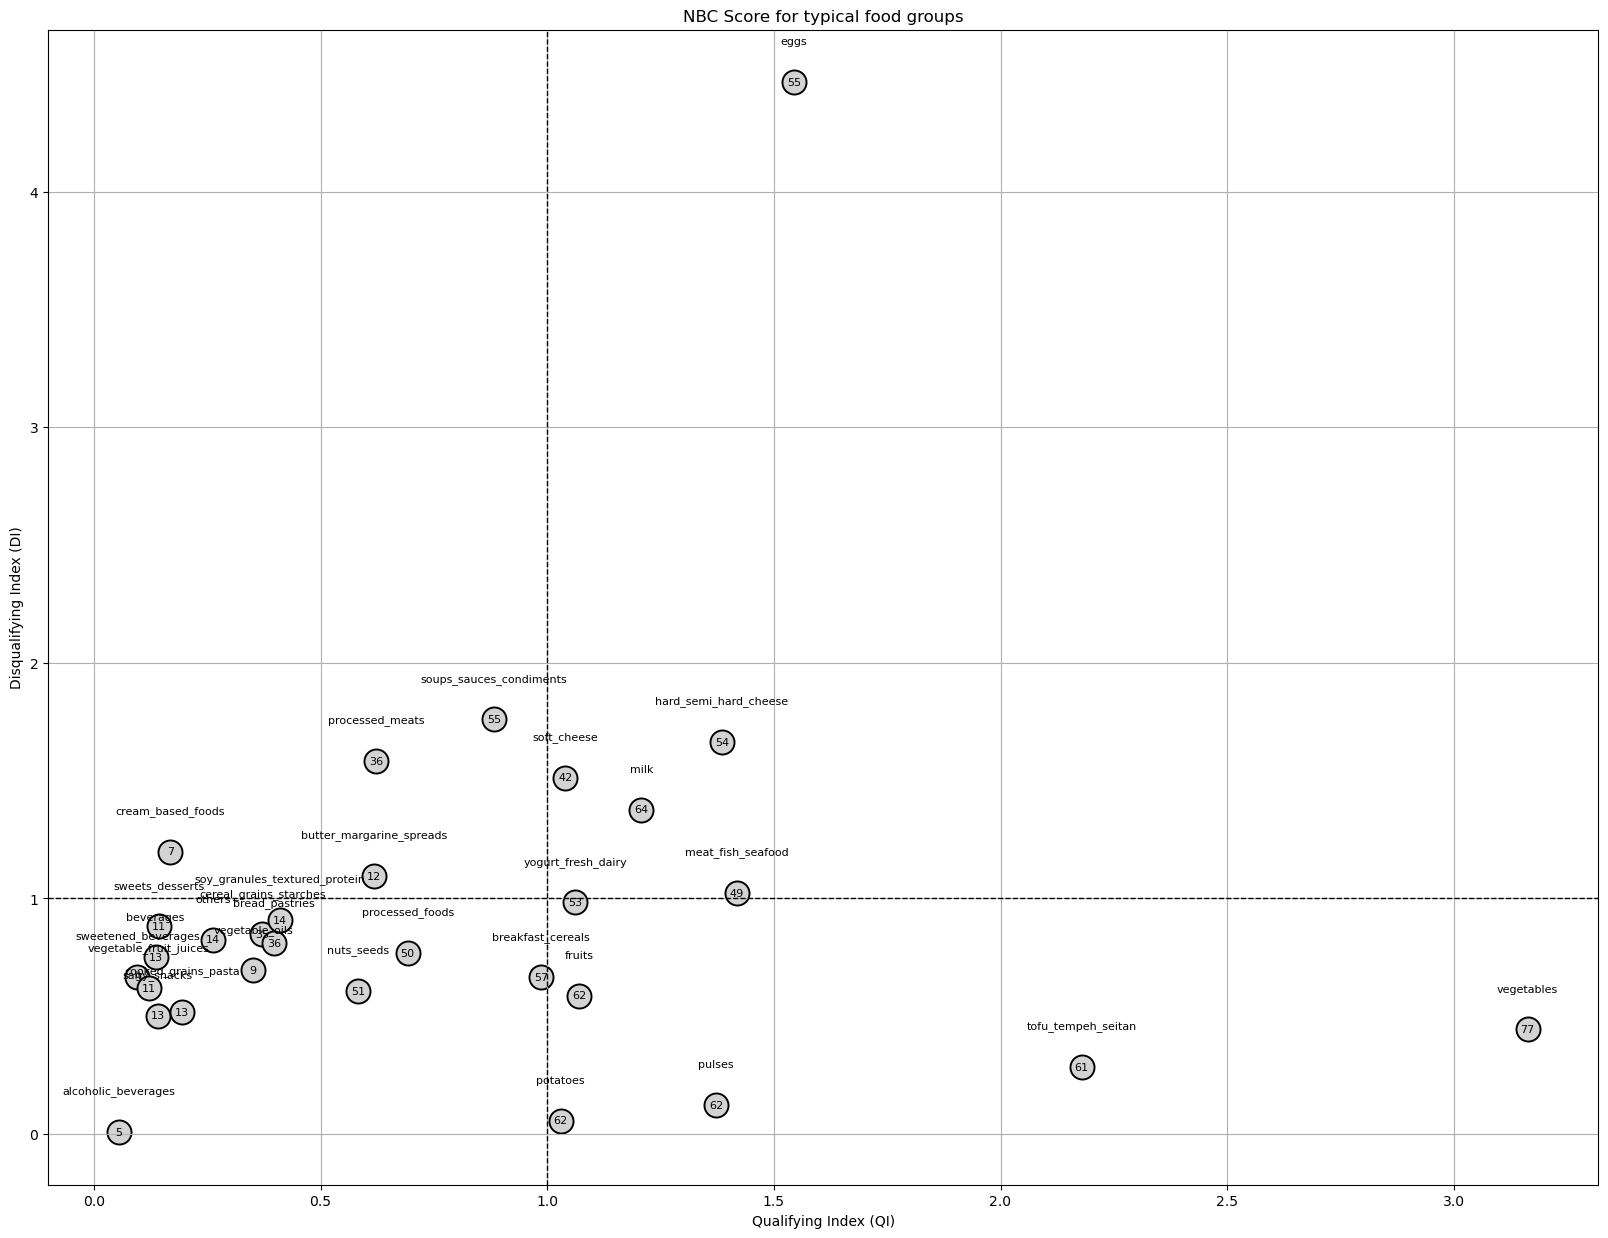

In [47]:
plt.figure(figsize=(20, 15))

data = df_food_scaled[['QI', 'DI', 'NB', 'combined_name', 'food_group']].groupby('food_group').median(numeric_only=True).sort_values('QI')

ax = sns.scatterplot(data=data, x='QI',y='DI',s=300,color='lightgray',edgecolor='black')

for i, row in data.iterrows():

    x = row['QI']
    y = row['DI']
    nb_values = row['NB']

    plt.text(x, y, f"{int(nb_values)}", ha='center', va='center', fontsize=8, zorder=10)

    plt.text(x, y + 0.15, i ,ha='center', va='bottom',fontsize=8, color='black', zorder=10)


plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)
plt.xlabel('Qualifying Index (QI)')
plt.ylabel('Disqualifying Index (DI)')
plt.title('NBC Score for typical food groups')
plt.grid()
plt.show()


In [48]:
df_food_scaled

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,protein_eaten_scaled,fat_eaten_scaled,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,365.100671,60.402685,22.818792,1181.208054,0.000000,1033.557047,0.000000,1.777322,1.029937,53.015229
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,365.100671,60.402685,22.818792,1181.208054,0.000000,1033.557047,0.000000,1.777322,1.029937,53.015229
26,26,0,192581,75.00,g,wrne8m,2021-03-12 18:00:06,60,1,vegetables_fruits,...,9.195402,4.597701,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517
31,26,0,375143,70.00,g,pb53wz,2022-07-19 17:03:51,120,1,vegetables_fruits,...,9.195402,4.597701,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517
37,26,0,424193,80.00,g,47649u,2023-03-01 11:36:40,60,1,vegetables_fruits,...,9.195402,4.597701,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514938,46472,7627534497637,422758,145.00,g,xek94s,2023-02-20 19:17:53,60,0,unclassified,...,76.923077,75.113122,0.000000,0.000000,0.000000,0.000000,9.954751,0.119446,0.437019,7.142857
514953,46528,7610200337689,421454,500.00,ml,kmxhmz,2023-02-16 06:56:02,60,1,unclassified,...,0.000000,0.000000,0.000000,0.000000,500.000000,0.000000,1.250000,0.000000,0.701389,0.000000
514954,46572,8853333016284,422430,200.00,ml,xek94s,2023-02-19 12:43:21,60,0,unclassified,...,0.000000,0.000000,0.000000,0.000000,466.666667,0.000000,2.333333,0.000000,0.687037,0.000000
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,98.630137,54.794521,8.219178,0.000000,257.534247,0.000000,5.753425,0.677614,0.682545,28.571429


# Classification of food into meals

In [49]:
df_food_scaled.groupby(["subject_key", "eaten_at"])["combined_name"].value_counts()

subject_key   eaten_at             combined_name                                  
02ae3856ca04  2018-11-26 07:47:34  Corn Flakes                                        1
                                   Yaourt, yahourt, yogourt ou yoghourt, natural      1
              2018-11-26 08:56:24  Banana                                             1
              2018-11-26 10:37:26  Rice                                               1
              2018-11-26 10:37:36  Balsamic salad dressing                            1
                                                                                     ..
zznk4w        2022-09-24 18:51:13  Pie, fruit, (average)                              1
              2022-09-25 05:56:39  Bread, wholewheat                                  1
              2022-09-25 06:11:11  Juice, orange                                      1
              2022-09-25 10:24:40  Porridge, prepared, with partially skimmed milk    1
              2022-09-25 10:36:35  Ca

In [50]:
def classify_meal_time(eaten_at):
    hour = eaten_at.hour

    if 5 <= hour < 11 :
        return 'breakfast'
    elif 11 <= hour < 16 :
        return 'lunch'
    else :
        return 'dinner'

In [51]:
df_food_scaled['eaten_at'] = pd.to_datetime(df_food_scaled['eaten_at'])
df_food_scaled['date'] = pd.to_datetime(df_food_scaled['eaten_at']).dt.date
df_food_scaled['meal'] = df_food_scaled['eaten_at'].apply(classify_meal_time)
df_food_scaled

,food_id,barcode,dish_id,eaten_quantity,eaten_unit,subject_key,eaten_at,eaten_at_utc_offset,media_count,food_group_cname,...,fatty_acids_saturated_eaten_scaled,cholesterol_eaten_scaled,sugar_eaten_scaled,sodium_eaten_scaled,salt_eaten_scaled,QI,DI,NB,date,meal
0,13,0,335994,110.00,g,bjsqab,2022-02-15 18:06:27,60,1,dairy_products_meat_fish_eggs_tofu,...,22.818792,1181.208054,0.000000,1033.557047,0.000000,1.777322,1.029937,53.015229,2022-02-15,dinner
3,13,0,411384,100.00,g,erv9jd,2023-01-18 13:08:53,60,1,dairy_products_meat_fish_eggs_tofu,...,22.818792,1181.208054,0.000000,1033.557047,0.000000,1.777322,1.029937,53.015229,2023-01-18,lunch
26,26,0,192581,75.00,g,wrne8m,2021-03-12 18:00:06,60,1,vegetables_fruits,...,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517,2021-03-12,dinner
31,26,0,375143,70.00,g,pb53wz,2022-07-19 17:03:51,120,1,vegetables_fruits,...,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517,2022-07-19,dinner
37,26,0,424193,80.00,g,47649u,2023-03-01 11:36:40,60,1,vegetables_fruits,...,0.000000,0.000000,464.367816,41.379310,0.000000,0.518944,0.631855,39.866517,2023-03-01,lunch
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
514938,46472,7627534497637,422758,145.00,g,xek94s,2023-02-20 19:17:53,60,0,unclassified,...,0.000000,0.000000,0.000000,0.000000,9.954751,0.119446,0.437019,7.142857,2023-02-20,dinner
514953,46528,7610200337689,421454,500.00,ml,kmxhmz,2023-02-16 06:56:02,60,1,unclassified,...,0.000000,0.000000,500.000000,0.000000,1.250000,0.000000,0.701389,0.000000,2023-02-16,breakfast
514954,46572,8853333016284,422430,200.00,ml,xek94s,2023-02-19 12:43:21,60,0,unclassified,...,0.000000,0.000000,466.666667,0.000000,2.333333,0.000000,0.687037,0.000000,2023-02-19,lunch
514957,46575,5411188102809,423445,100.00,g,kmxhmz,2023-02-25 08:18:11,60,1,unclassified,...,8.219178,0.000000,257.534247,0.000000,5.753425,0.677614,0.682545,28.571429,2023-02-25,breakfast


In [52]:
df_food_scaled.groupby(['subject_key', 'meal','energy_kcal_eaten', 'date', 'QI', 'DI', 'NB'])['combined_name'].value_counts()

subject_key   meal       energy_kcal_eaten  date        QI        DI        NB         combined_name                                
02ae3856ca04  breakfast  69.00              2018-11-29  3.484986  2.612482  85.807946  Tomato sauce                                     1
                         71.10              2018-11-29  0.371371  0.847247  35.603925  Couscous                                         1
                         94.20              2018-12-06  1.544642  4.464696  55.882138  Egg                                              1
                         95.00              2018-11-26  1.070674  0.513713  62.390552  Banana                                           1
                         99.00              2018-11-26  1.394111  1.208269  68.372501  Yaourt, yahourt, yogourt ou yoghourt, natural    1
                                                                                                                                       ..
zznk4w        lunch      213.00        

In [53]:

# Compute the weighted mean of a set of values usinf the corresponding weight
def weighted_mean(values, weights):
    if weights.sum() != 0:
        return (values * weights).sum() / weights.sum()
    else:
        return np.nan

def aggregate_meal(group):

    total_energy = group['energy_kcal_eaten'].sum()
    # Food item with larger energy will have a greater influence on the overall index 
    qi = weighted_mean(group['QI'], group['energy_kcal_eaten'])
    di = weighted_mean(group['DI'], group['energy_kcal_eaten'])
    nb = weighted_mean(group['NB'], group['energy_kcal_eaten'])

    return pd.Series({
        'total_energy': total_energy,
        'QI': qi,
        'DI': di,
        'NB': nb
    })



In [54]:
meal_summary_weighted = df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index()

C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\332498296.py:1: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meal_summary_weighted = df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index()


In [55]:
meal_summary_weighted

,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-11-26,breakfast,783.100,0.479270,0.952523,32.601740
1,02ae3856ca04,2018-11-26,dinner,1293.100,0.592939,0.606672,33.689711
2,02ae3856ca04,2018-11-26,lunch,402.200,0.855206,1.389317,33.040560
3,02ae3856ca04,2018-11-27,breakfast,465.700,0.686219,0.682723,47.330638
4,02ae3856ca04,2018-11-27,dinner,1270.700,0.297503,0.579577,21.026286
...,...,...,...,...,...,...,...
38545,zznk4w,2022-09-23,dinner,1399.325,1.396953,0.928856,54.864129
38546,zznk4w,2022-09-24,breakfast,216.000,0.225155,0.503604,14.285714
38547,zznk4w,2022-09-24,dinner,1150.700,0.494931,1.130038,33.745690
38548,zznk4w,2022-09-24,lunch,710.250,0.212162,0.741355,20.044952


In [56]:
summary_by_meal = meal_summary_weighted.groupby('meal')[['QI', 'DI', 'NB', 'total_energy']].mean().reset_index()
summary_by_meal

,meal,QI,DI,NB,total_energy
0,breakfast,0.819212,0.980055,38.560246,467.952683
1,dinner,0.889606,0.912729,36.899659,668.179548
2,lunch,0.917777,0.934038,37.590488,485.403216


In [57]:
daily_total_energy = meal_summary_weighted.groupby(['subject_key', 'date'])['total_energy'].sum().reset_index().sort_values('total_energy',ascending=True)
daily_total_energy


,subject_key,date,total_energy
8982,nca5h9,2022-11-19,55.0000
4385,c883gq,2020-04-19,55.2000
4894,dfhgtr,2020-11-23,63.0000
7447,jcdzcr,2020-10-19,63.2500
13699,xg329g,2021-04-06,67.5000
...,...,...,...
14558,z8q7px,2019-12-21,4634.7500
10725,rr58q5,2022-07-22,4788.2900
13534,xcmwrd,2020-06-27,5031.7000
13876,xxypv2,2019-04-12,5052.5400


In [58]:
print('Average total energy for a day :', daily_total_energy['total_energy'].mean())

Average total energy for a day : 1405.5727451761368


### Largest meal in kcal (breakfast, lunch, dinner)

In [59]:
largest_breakfast = (meal_summary_weighted[meal_summary_weighted['meal'] == 'breakfast'].sort_values('total_energy').groupby('subject_key').last() .reset_index())
largest_breakfast


,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-11-26,breakfast,783.10,0.479270,0.952523,32.601740
1,223h73,2019-08-21,breakfast,1357.10,0.532901,0.802382,30.220019
2,22w6cq,2020-02-05,breakfast,474.90,0.490692,0.963721,24.377332
3,244bwh,2020-08-31,breakfast,757.75,0.592274,1.245975,25.686844
4,2857fm,2019-10-14,breakfast,1119.87,0.632362,0.839581,52.239723
...,...,...,...,...,...,...,...
1004,zwsy9r,2020-07-20,breakfast,643.68,0.638792,1.099873,53.895312
1005,zxq62h,2022-07-19,breakfast,1195.90,1.327550,0.082891,24.700118
1006,zy5e65,2022-01-17,breakfast,1076.75,0.021993,0.219226,2.199294
1007,zyt7da,2020-03-26,breakfast,733.36,0.493586,0.522584,23.132194


In [60]:
largest_lunch = (meal_summary_weighted[meal_summary_weighted['meal'] == 'lunch'].sort_values('total_energy').groupby('subject_key').last().reset_index())
largest_lunch

,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-11-28,lunch,1598.40000,0.907503,1.555374,56.140974
1,223h73,2019-09-02,lunch,1650.69000,0.139397,0.492012,8.624438
2,22w6cq,2020-01-26,lunch,1274.16752,0.170245,0.167817,15.468944
3,244bwh,2020-09-01,lunch,565.28000,0.585278,0.730852,47.142464
4,2857fm,2019-10-07,lunch,1679.57000,0.524899,0.704389,42.833730
...,...,...,...,...,...,...,...
1002,zwsy9r,2020-07-21,lunch,1274.55000,1.190873,1.619590,49.916474
1003,zxq62h,2022-07-30,lunch,774.70000,0.386627,0.877822,23.842386
1004,zy5e65,2022-02-05,lunch,1044.00000,0.293562,0.489877,26.558748
1005,zyt7da,2020-03-13,lunch,1225.55000,0.647936,0.538617,46.773495


In [61]:
largest_dinner = (meal_summary_weighted[meal_summary_weighted['meal'] == 'dinner'].sort_values('total_energy').groupby('subject_key').last() .reset_index())
# .last(), meal with the highest total energy
largest_dinner

,subject_key,date,meal,total_energy,QI,DI,NB
0,02ae3856ca04,2018-12-07,dinner,3136.40000,0.476092,0.969520,42.676647
1,223h73,2019-09-01,dinner,2099.62000,0.873963,0.703776,47.421157
2,22w6cq,2020-01-25,dinner,1312.25128,0.595031,0.500788,28.345945
3,244bwh,2020-09-04,dinner,828.60000,0.709003,1.093277,29.615333
4,2857fm,2019-10-04,dinner,3337.10871,0.242011,0.664618,22.906759
...,...,...,...,...,...,...,...
1002,zwsy9r,2020-07-30,dinner,892.30000,0.859254,0.608273,37.426898
1003,zxq62h,2022-07-23,dinner,995.95000,0.200056,0.765143,16.359433
1004,zy5e65,2022-02-02,dinner,1277.85000,0.347464,1.166786,17.434693
1005,zyt7da,2020-03-14,dinner,1723.30000,0.624341,1.191933,28.219737


In [62]:
largest_meals = pd.concat([largest_breakfast, largest_lunch, largest_dinner])

# Now group by 'meal' to get average QI, DI, and NB for each meal type
summary_by_high_meal = largest_meals.groupby('meal')[['QI', 'DI', 'NB', 'total_energy']].median().reset_index()
summary_by_high_meal


,meal,QI,DI,NB,total_energy
0,breakfast,0.578727,0.850255,36.044188,949.8
1,dinner,0.557818,0.782722,32.575025,1360.5
2,lunch,0.578944,0.822406,34.246267,1023.4


In [63]:
subject = 'bryt9h'
target_date = pd.to_datetime('2019-06-17').date()
meal_type = 'breakfast'

df_subject_meal = df_food_scaled[
    (df_food_scaled['subject_key'] == subject) &
    (df_food_scaled['date'] == target_date) &
    (df_food_scaled['meal'] == meal_type)
]


In [64]:
df_subject_meal[['energy_kcal_eaten','eaten_at', 'combined_name', 'QI', 'DI', 'NB']]


,energy_kcal_eaten,eaten_at,combined_name,QI,DI,NB
448256,103.65,2019-06-17 05:56:28,"Greek Yaourt, yahourt, yogourt ou yoghourt",1.333872,1.070352,48.155154
474625,212.50,2019-06-17 10:23:32,MClassic - Saladbowl Chicken,3.114809,1.645896,78.584500


In [65]:
df_food[df_food['combined_name'] == 'Coca-Cola Energy'][['energy_kcal_eaten','niacin_eaten','pantothenic_acid_eaten', 'vitamin_b12_eaten', 'vitamin_b6_eaten']]

,energy_kcal_eaten,niacin_eaten,pantothenic_acid_eaten,vitamin_b12_eaten,vitamin_b6_eaten


In [66]:
#df_food_scaled[df_food_scaled['combined_name'] == 'Coca-Cola Energy'][['energy_kcal_eaten','niacin_eaten_scaled','pantothenic_acid_eaten_scaled', 'vitamin_b12_eaten_scaled', 'vitamin_b6_eaten_scaled']]

In [67]:
qi_ratios[qi_ratios['combined_name'] == 'MClassic - Saladbowl Chicken'].T

,474624,474625
folate_eaten_ratio,1.723529,1.723529
all_trans_retinol_equivalents_activity_eaten_ratio,0.0,0.0
beta_carotene_eaten_ratio,21.07563,21.07563
vitamin_c_eaten_ratio,0.348235,0.348235
vitamin_d_eaten_ratio,0.0,0.0
vitamin_e_activity_eaten_ratio,3.513725,3.513725
calcium_eaten_ratio,2.352941,2.352941
iron_eaten_ratio,0.653595,0.653595
magnesium_eaten_ratio,1.397059,1.397059
phosphorus_eaten_ratio,5.042017,5.042017


In [68]:
qi_ratios[qi_ratios['combined_name'] == 'Red Bull Zero Calories'].T

""
folate_eaten_ratio
all_trans_retinol_equivalents_activity_eaten_ratio
beta_carotene_eaten_ratio
vitamin_c_eaten_ratio
vitamin_d_eaten_ratio
vitamin_e_activity_eaten_ratio
calcium_eaten_ratio
iron_eaten_ratio
magnesium_eaten_ratio
phosphorus_eaten_ratio


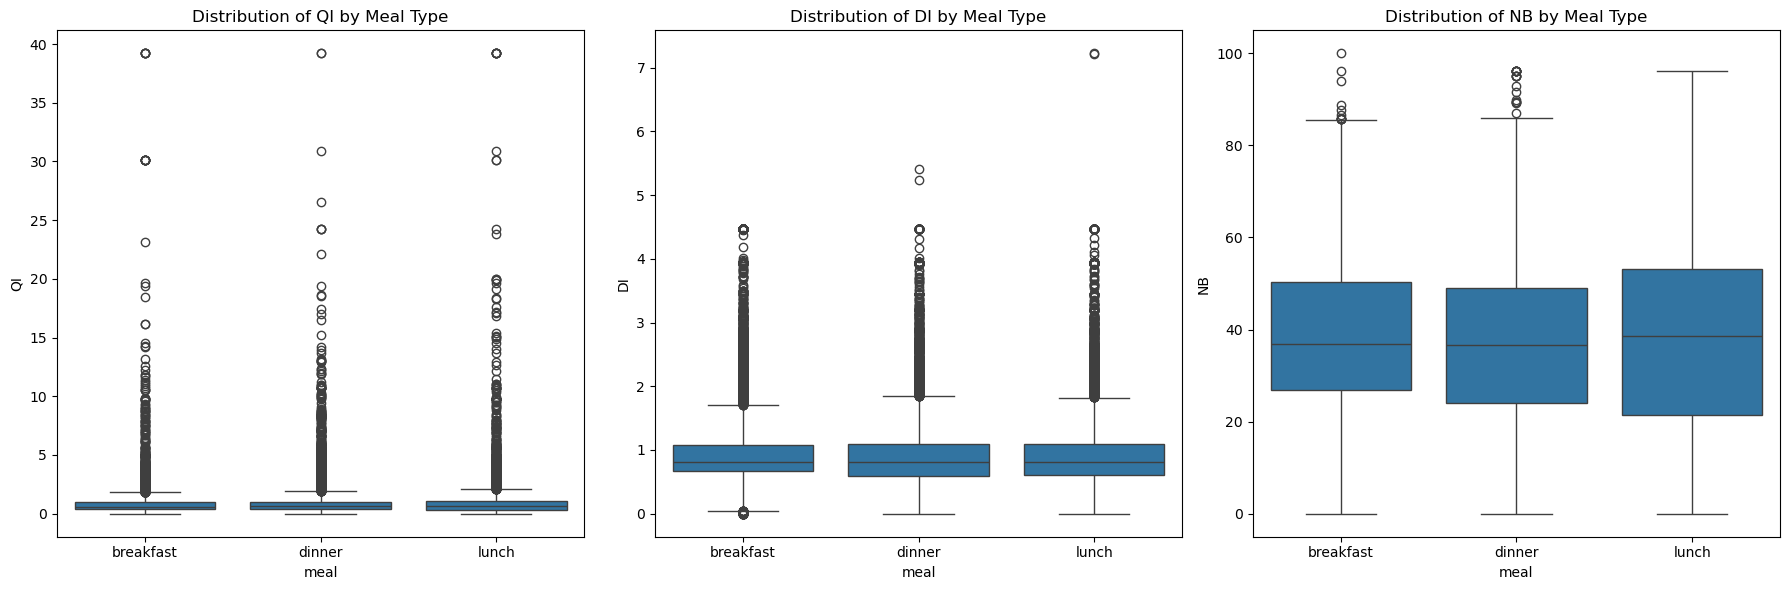

In [69]:
fig, axes = plt.subplots(ncols=3, figsize=(18, 6), sharey=False)


sns.boxplot(x='meal', y='QI', data=meal_summary_weighted, ax=axes[0])
axes[0].set_title('Distribution of QI by Meal Type')

sns.boxplot(x='meal', y='DI', data=meal_summary_weighted, ax=axes[1])
axes[1].set_title('Distribution of DI by Meal Type')

sns.boxplot(x='meal', y='NB', data=meal_summary_weighted, ax=axes[2])
axes[2].set_title('Distribution of NB by Meal Type')

plt.tight_layout()
plt.show()

In [70]:
meal_summary_weighted.sort_values('QI', ascending=False).head(30)

,subject_key,date,meal,total_energy,QI,DI,NB
20236,kc2j69,2020-03-27,lunch,60.80,39.209308,0.731399,79.700156
34425,wsr4ra,2020-05-25,breakfast,60.80,39.209308,0.731399,79.700156
22879,n7mdum,2020-05-29,lunch,57.00,39.209308,0.731399,79.700156
21326,kyksrj,2021-05-21,lunch,60.80,39.209308,0.731399,79.700156
12276,d95qcy,2021-10-12,lunch,68.40,39.209308,0.731399,79.700156
18754,j3kvkn,2021-05-18,breakfast,60.80,39.209308,0.731399,79.700156
12261,d95qcy,2021-10-07,breakfast,60.80,39.209308,0.731399,79.700156
22867,n6v4kb,2023-02-05,lunch,60.80,39.209308,0.731399,79.700156
6115,7gduc3,2021-04-30,dinner,114.00,39.209308,0.731399,79.700156
3964,5pf73y,2019-04-07,dinner,76.00,39.209308,0.731399,79.700156


In [71]:
qi_ratios[['combined_name', 'QI']].drop_duplicates('combined_name').sort_values('QI', ascending=False).head(30)

,combined_name,QI
4611,"Spinach, raw",55.004716
4458,"Spinach, steamed, without addition of salt",47.973909
55444,"Carrot, raw",39.209308
466981,Coop Naturaplan Bio - Rüeblisalat (Vegan),39.209308
481245,Migros Fresca - Snack Karotten,39.209308
471426,Chopped spinach,36.683545
1531,"Carrot, steamed, without addition of salt",36.431783
55398,Turnip,36.297055
60629,"Carrot (old variety, white)",36.297055
27054,"Salad, rocket",33.720848



- Coca-Cola Energy
- Red Bull Zero Calories
- Chicken caesar salad (green salad, cheese, croutons, sauce)

-------------------------------------------------------

- niacin_eaten_ratio
- pantothenic_acid_eaten_ratio
- vitamin_b12_eaten_ratio
- vitamin_b6_eaten_ratio
- vitamin_b1_eaten_ratio
- vitamin_b2_eaten_ratio


In [72]:
df_food_scaled.groupby(['subject_key', 'meal', 'date',])["combined_name"].value_counts()

subject_key   meal       date        combined_name                                
02ae3856ca04  breakfast  2018-11-26  Balsamic salad dressing                          1
                                     Banana                                           1
                                     Corn Flakes                                      1
                                     Rice                                             1
                                     Yaourt, yahourt, yogourt ou yoghourt, natural    1
                                                                                     ..
zznk4w        lunch      2022-09-18  Pasta, spaghetti                                 1
                         2022-09-20  Pie, plum, baked, with cake dough                2
                         2022-09-22  Pasta, spaghetti                                 1
                         2022-09-24  Banana cake                                      2
                                     

In [73]:
"""
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-11-26').date()
meal_name = 'breakfast'

# 1. Filter
df_breakfast = df_food_scaled[
    (df_food_scaled['subject_key'] == subject_id) &
    (df_food_scaled['date'] == target_date) &
    (df_food_scaled['meal'] == meal_name)
].copy()

# 2. Include 'eaten_at' so we can sort in consumption order
df_breakfast = df_breakfast[['combined_name', 'QI', 'DI', 'NB', 'eaten_at']].drop_duplicates('combined_name')

# If you don't have 'eaten_at', remove the .sort_values(...) line and skip the polygon approach

# 3. Sort by time (consumption order)
df_breakfast = df_breakfast.sort_values('eaten_at')

# 4. Compute combined meal
combined_qi = df_breakfast['QI'].mean()
combined_di = df_breakfast['DI'].mean()
combined_nb = df_breakfast['NB'].mean()

# 5. Prepare the polygon coordinates
x_coords = df_breakfast['QI'].tolist()
y_coords = df_breakfast['DI'].tolist()

# 6. Close the polygon by repeating the first point at the end
if len(x_coords) > 1:
    x_coords.append(x_coords[0])
    y_coords.append(y_coords[0])

plt.figure(figsize=(15, 9))

# 7. Fill the polygon (lightblue) and connect the points in black
#    Only if you have more than 2 items to form a polygon
if len(x_coords) > 2:
    plt.fill(x_coords, y_coords, alpha=0.2, color='lightblue', zorder=1)
    plt.plot(x_coords, y_coords, color='black', linestyle='-', zorder=2)

# 8. Plot each item as a circle
#    We'll do this manually instead of sns.scatterplot so we can control the polygon layering
for idx in range(len(df_breakfast)):
    row = df_breakfast.iloc[idx]
    x = row['QI']
    y = row['DI']
    nb_val = int(row['NB'])
    
    # Circle
    plt.scatter(x, y, s=300, color='lightgray', edgecolor='black', zorder=3)
    
    # NB in center
    plt.text(x, y, f"{nb_val}", ha='center', va='center', fontsize=8, color='black', zorder=4)
    
    # Food name offset
    plt.text(x + 0.05, y + 0.05, row['combined_name'], 
             ha='left', va='bottom', fontsize=8, color='black', zorder=4)

# 9. Plot the combined meal point (large circle with red outline)
plt.scatter(combined_qi, combined_di, s=400, color='white', edgecolors='red', zorder=5)
plt.text(combined_qi, combined_di, str(int(combined_nb)), 
         ha='center', va='center', color='red', fontsize=10, zorder=6)
plt.text(combined_qi, combined_di + 0.1, 'Combined Meal', 
         ha='center', va='bottom', color='red', fontsize=9, zorder=6)

# 10. Dashed lines at QI=1 and DI=1
plt.axvline(x=1, color='black', linestyle='--', linewidth=1)
plt.axhline(y=1, color='black', linestyle='--', linewidth=1)

# 11. Set x-axis and y-axis limits
plt.xlim(0, 5)
plt.ylim(0, 2)

# 12. Show only ticks at y=1 and y=2
plt.yticks([1, 2])

plt.xlabel('Qualifying Index (QI)')
plt.ylabel('Disqualifying Index (DI)')
plt.title(f'Day 1 {meal_name} on subject : {subject_id}')
plt.grid()
plt.show()

print("Combined NB:", combined_nb)"
"""


'\nsubject_id = \'02ae3856ca04\'\ntarget_date = pd.to_datetime(\'2018-11-26\').date()\nmeal_name = \'breakfast\'\n\n# 1. Filter\ndf_breakfast = df_food_scaled[\n    (df_food_scaled[\'subject_key\'] == subject_id) &\n    (df_food_scaled[\'date\'] == target_date) &\n    (df_food_scaled[\'meal\'] == meal_name)\n].copy()\n\n# 2. Include \'eaten_at\' so we can sort in consumption order\ndf_breakfast = df_breakfast[[\'combined_name\', \'QI\', \'DI\', \'NB\', \'eaten_at\']].drop_duplicates(\'combined_name\')\n\n# If you don\'t have \'eaten_at\', remove the .sort_values(...) line and skip the polygon approach\n\n# 3. Sort by time (consumption order)\ndf_breakfast = df_breakfast.sort_values(\'eaten_at\')\n\n# 4. Compute combined meal\ncombined_qi = df_breakfast[\'QI\'].mean()\ncombined_di = df_breakfast[\'DI\'].mean()\ncombined_nb = df_breakfast[\'NB\'].mean()\n\n# 5. Prepare the polygon coordinates\nx_coords = df_breakfast[\'QI\'].tolist()\ny_coords = df_breakfast[\'DI\'].tolist()\n\n# 6. Clos

# Statistical Tests

In [74]:

def significance_test(data, group_col, value_col, alpha=0.05, non_parametric=False):
    groups = data[group_col].unique()
    if len(groups) == 2:
        group1 = data[data[group_col] == groups[0]][value_col]
        group2 = data[data[group_col] == groups[1]][value_col]
        if non_parametric:
            stat, p_val = mannwhitneyu(group1, group2)
            test_name = "Mann-Whitney U"
        else:
            stat, p_val = ttest_ind(group1, group2)
            test_name = "t-test"
        return p_val < alpha, p_val, test_name, stat
    elif len(groups) > 2:
        group_values = [data[data[group_col] == grp][value_col] for grp in groups]
        if non_parametric:
            stat, p_val = kruskal(*group_values)
            test_name = "Kruskal-Wallis"
        else:
            stat, p_val = f_oneway(*group_values)
            test_name = "ANOVA"
        return p_val < alpha, p_val, test_name, stat
    return False, 1.0, "No test", 0
def create_quartiles(df, column_name, ncut=4):
    """Add quartile categories (1-4) for a specified column in a DataFrame."""
    df_copy = df.copy()
    df_copy[column_name + "_quartile"] = pd.qcut(
        df_copy[column_name], q=ncut, labels=[f"Q{i}" for i in range(1, ncut + 1)]
    )
    return df_copy
def add_stat_annotation(ax, data, x, y, pairs, test="Mann-Whitney", text_format="star"):
    """Add statistical annotation bars to the plot."""
    annotator = Annotator(ax, pairs, data=data, x=x, y=y)
    annotator.configure(
        test=test,
        text_format=text_format,
        line_width=0.5,  # Thinner lines
        line_height=0.02,
    )  # Slightly shorter bars
    annotator.apply_and_annotate()
def test_quartile_differences(
    df,
    column_name,
    value_col,
    extremes=True,
    alpha=0.05,
    non_parametric=True,
    ax=None,
    palette="Spectral",
    make_quartile=True,
    verbose=False,
):
    """
    Test differences between quartiles of a specified column and create a boxplot with significance bars.
    """
    df = df.copy()
    if make_quartile:
        df = create_quartiles(df, column_name)
        quartile_col = column_name + "_quartile"
    else:
        quartile_col = column_name
    if extremes:
        df = df[df[quartile_col].isin(["Q1", "Q4"])]
        if isinstance(df[quartile_col].dtype, pd.CategoricalDtype):
            df[quartile_col] = df[quartile_col].cat.remove_unused_categories()
    # Create plot if ax not provided
    if ax is None:
        fig, ax = plt.subplots(1, 1, figsize=(3, 3))
    # Create boxplot
    sns.boxplot(
        data=df,
        x=quartile_col,
        y=value_col,
        ax=ax,
        linewidth=0.5,
        fliersize=1,
        width=0.5,
        palette=palette,
    )
    # Get unique groups and create pairs for comparison
    groups = sorted(df[quartile_col].dropna().astype(str).unique())
    if extremes:
        # If only comparing extremes, just compare Q1 and Q4
        pairs = [("Q1", "Q4")]
    else:
        # Create all possible pairs of quartiles
        pairs = list(combinations(groups, 2))
    # Determine statistical test
    test = "Mann-Whitney" if non_parametric else "t-test"
    # Add statistical annotation
    add_stat_annotation(ax, df, x=quartile_col, y=value_col, pairs=pairs, test=test)
    # Run the original significance test for console output
    is_sig, p_val, test_name, stat = significance_test(
        df, quartile_col, value_col, alpha=alpha, non_parametric=non_parametric
    )
    if verbose:
        if is_sig:
            print(
                f"{column_name} -> {value_col}\tSignificant differences exist.",
                f"{test_name} statistic: {stat:.3f} p-value: {p_val:.3f}",
            )
        else:
            print(f"{column_name} -> {value_col}\tNo significant differences.")
    # Add test statistics to plot
    ylims = ax.get_ylim()
    yrange = ylims[1] - ylims[0]
    text_y = ylims[1] + yrange * 0.05  # Position text above the plot
    # Format test information with abbreviated names
    test_abbrev = {
        "Kruskal-Wallis": "KW",
        "Mann-Whitney U": "MW",
        "ANOVA": "ANOVA",
        "t-test": "t-test",
    }
    abbreviated_name = test_abbrev.get(test_name, test_name)
    if test_name == "Kruskal-Wallis":
        test_info = f"${abbreviated_name}:$ $H={stat:.2f}$, $p={p_val:.3f}$"
    elif test_name == "Mann-Whitney U":
        test_info = f"${abbreviated_name}:$ $U={stat:.2f}$, $p={p_val:.3f}$"
    else:
        test_info = f"${abbreviated_name}:$ $t={stat:.2f}$, $p={p_val:.3f}$"
    # Add text with test information
    ax.text(
        0,
        text_y,
        test_info,
        horizontalalignment="left",
        verticalalignment="bottom",
        fontsize=8,
    )
    # Adjust plot limits to accommodate the text
    ax.set_ylim(ylims[0], ylims[1] + yrange * 0.15)
    return ax


In [75]:
largest_meals.columns

Index(['subject_key', 'date', 'meal', 'total_energy', 'QI', 'DI', 'NB'], dtype='object')

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:2.141e-02 U_stat=5.381e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.067e-01 U_stat=5.281e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:4.719e-05 U_stat=5.612e+05


C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='meal', ylabel='NB'>

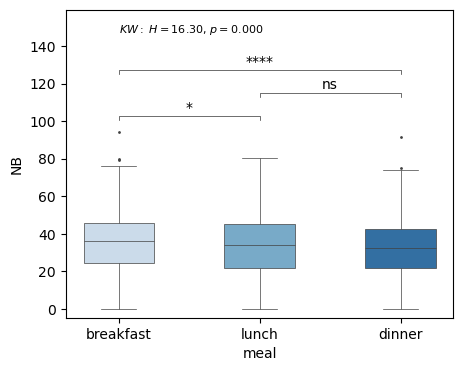

In [76]:
fig, ax = plt.subplots(1, 1, figsize=(5,4)) 
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'NB', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:8.253e-01 U_stat=5.109e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:3.006e-01 U_stat=5.205e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.970e-01 U_stat=5.249e+05


C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='meal', ylabel='QI'>

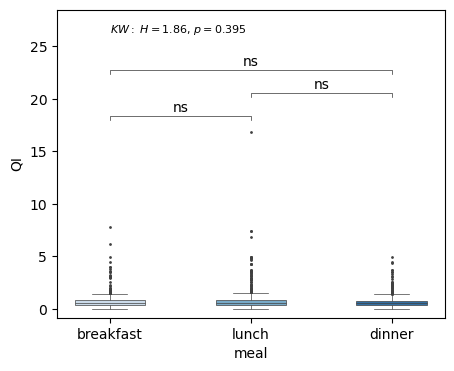

In [77]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))  
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'QI', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)

p-value annotation legend:
      ns: 5.00e-02 < p <= 1.00e+00
       *: 1.00e-02 < p <= 5.00e-02
      **: 1.00e-03 < p <= 1.00e-02
     ***: 1.00e-04 < p <= 1.00e-03
    ****: p <= 1.00e-04

breakfast vs. lunch: Mann-Whitney-Wilcoxon test two-sided, P_val:5.591e-03 U_stat=5.442e+05
lunch vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:8.598e-03 U_stat=5.413e+05
breakfast vs. dinner: Mann-Whitney-Wilcoxon test two-sided, P_val:1.032e-07 U_stat=5.776e+05


C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\363652421.py:69: FutureWarning: 

Passing `palette` without assigning `hue` is deprecated and will be removed in v0.14.0. Assign the `x` variable to `hue` and set `legend=False` for the same effect.

  sns.boxplot(


<Axes: xlabel='meal', ylabel='DI'>

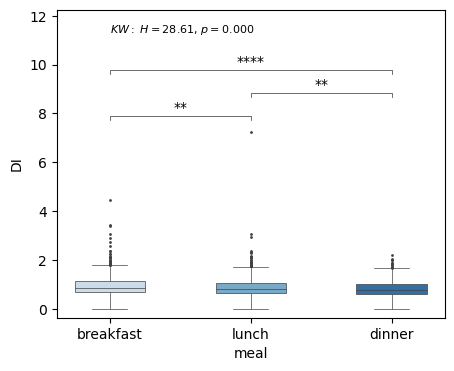

In [78]:
fig, ax = plt.subplots(1, 1, figsize=(5,4))
test_quartile_differences(
    largest_meals, # your dataframe
    'meal', # grouping column (e.g good or bad food group)
    'DI', # target column e.g NB or QI or DI
    extremes=False,
    make_quartile=False,
    palette="Blues",
    verbose=False,
    ax=ax,
)

## QI, DI, NB and energy consumption over time 

In [79]:
def plot_subject_daywise(subject_id, df_food_scaled):

    # Daily median
    daily_nutrient_medians = (df_food_scaled.groupby(['subject_key', 'date'])[['QI', 'DI', 'NB']].median().reset_index())
    
    # Compute meal-level weighted aggregates
    meal_summary_weighted = (df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index())
    
    # Filter for the specific subject
    subject_daily = daily_nutrient_medians[daily_nutrient_medians['subject_key'] == subject_id]
    subject_meals = meal_summary_weighted[meal_summary_weighted['subject_key'] == subject_id]
    
    # total_energy by meal type for each day
    pivot_energy = subject_meals.pivot(index='date', columns='meal', values='total_energy')


    # Plot : Daywise Nutrient Quality 
    fig, ax1 = plt.subplots(figsize=(12,6))
    
    # QI and DI axis
    ax1.plot(subject_daily['date'], subject_daily['QI'], label='QI', marker='o', color='blue')
    ax1.plot(subject_daily['date'], subject_daily['DI'], label='DI', marker='o', color='green')
    ax1.set_xlabel('Date')
    ax1.set_ylabel('QI, DI', color='black')
    ax1.tick_params(axis='y', labelcolor='black')
    ax1.set_ylim(0, 1.5)
    
    # NB axis
    ax2 = ax1.twinx()
    ax2.plot(subject_daily['date'], subject_daily['NB'], label='NB', marker='o', color='red')
    ax2.set_ylabel('NB (%)', color='red')
    ax2.tick_params(axis='y', labelcolor='red')
    ax2.set_ylim(0, 100)
    
    lines1, labels1 = ax1.get_legend_handles_labels()
    lines2, labels2 = ax2.get_legend_handles_labels()
    ax1.legend(lines1 + lines2, labels1 + labels2, loc='upper left')
    
    plt.title(f'QI, DI and NB over time for Subject : {subject_id}')
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()
    

    # Plot : Bar Chart of Daily Energy Consumption by Meal Type
    pivot_energy.plot(kind='bar', figsize=(12,6))
    plt.title(f"Daily Energy Consumption by Meal Type for Subject : {subject_id}")
    plt.ylabel("Total Energy (kcal)")
    plt.xticks(rotation=45)
    plt.tight_layout()
    plt.show()

    print(subject_daily)
    
    return subject_daily, subject_meals, pivot_energy

C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\1070765091.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meal_summary_weighted = (df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index())


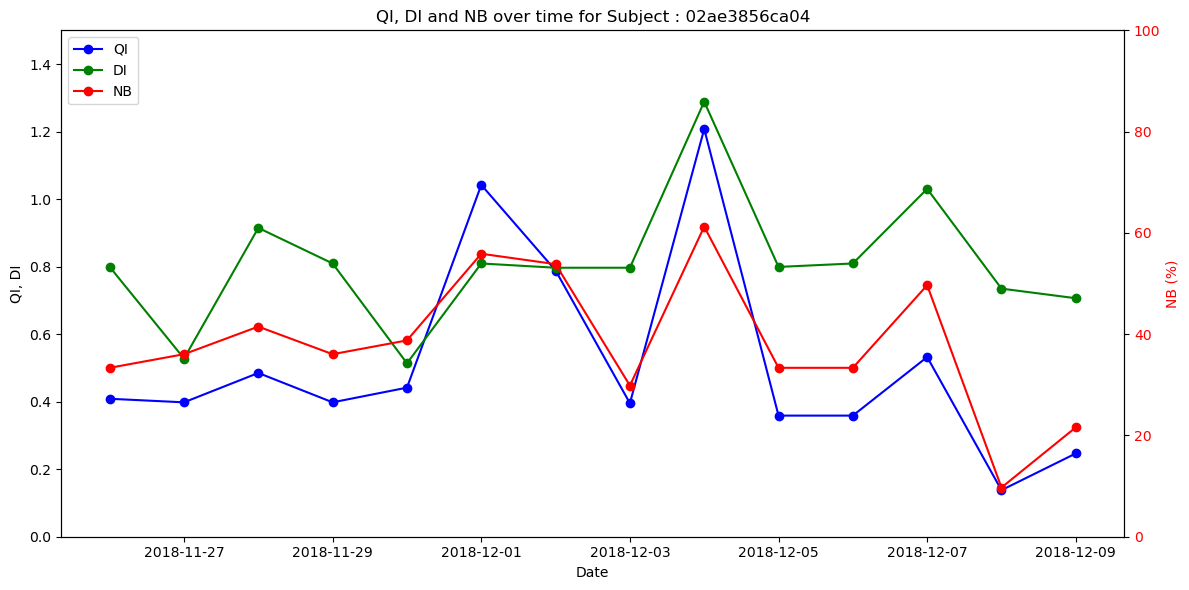

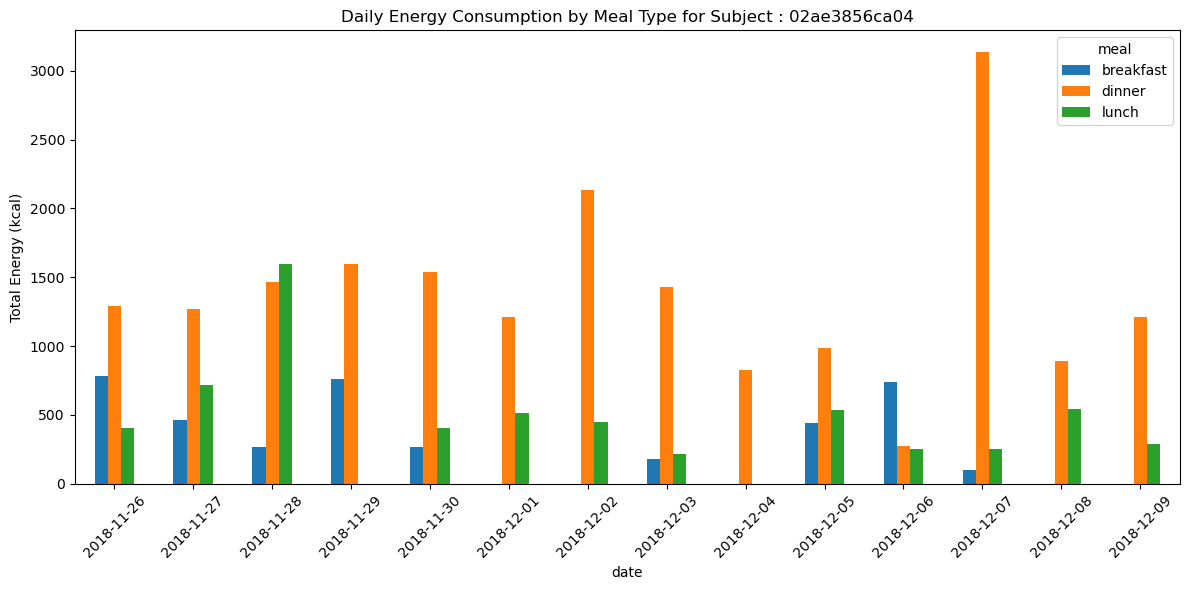

     subject_key        date        QI        DI         NB
0   02ae3856ca04  2018-11-26  0.408630  0.799168  33.354575
1   02ae3856ca04  2018-11-27  0.398094  0.527859  36.044188
2   02ae3856ca04  2018-11-28  0.485072  0.914794  41.492872
3   02ae3856ca04  2018-11-29  0.398094  0.809386  36.044188
4   02ae3856ca04  2018-11-30  0.441583  0.513713  38.768530
5   02ae3856ca04  2018-12-01  1.042181  0.809386  55.882138
6   02ae3856ca04  2018-12-02  0.788587  0.796765  53.825697
7   02ae3856ca04  2018-12-03  0.395433  0.796788  29.849223
8   02ae3856ca04  2018-12-04  1.207900  1.288723  61.234318
9   02ae3856ca04  2018-12-05  0.358758  0.799168  33.354575
10  02ae3856ca04  2018-12-06  0.358758  0.809386  33.354575
11  02ae3856ca04  2018-12-07  0.532278  1.030415  49.670662
12  02ae3856ca04  2018-12-08  0.137936  0.734886   9.715461
13  02ae3856ca04  2018-12-09  0.246642  0.706447  21.593523


In [80]:
subject_id = '02ae3856ca04'
subject_daily, subject_meals, pivot_energy = plot_subject_daywise(subject_id, df_food_scaled)

In [81]:
specific_date = pd.to_datetime('2018-12-01').date()
df_specific = df_food_scaled[(df_food_scaled['subject_key'] == '02ae3856ca04') & (df_food_scaled['date'] == specific_date)][['energy_kcal_eaten', 'date', 'QI', 'DI', 'NB', 'meal']].sort_values('date')
df_specific



,energy_kcal_eaten,date,QI,DI,NB,meal
81687,95.00,2018-12-01,1.070674,0.513713,62.390552,lunch
126884,324.00,2018-12-01,1.042181,2.168672,56.964689,dinner
152720,156.00,2018-12-01,0.193661,0.517566,13.369963,dinner
173717,242.00,2018-12-01,0.398094,0.809386,36.044188,dinner
208821,86.35,2018-12-01,1.544642,4.464696,55.882138,dinner
382295,141.60,2018-12-01,0.061822,0.045792,6.182230,dinner
382296,155.76,2018-12-01,0.061822,0.045792,6.182230,dinner
416240,126.00,2018-12-01,1.520792,0.344967,47.057553,lunch
433906,103.20,2018-12-01,0.673187,1.015470,64.834924,dinner
459465,175.00,2018-12-01,1.387448,1.180306,68.284742,lunch


C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\1070765091.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meal_summary_weighted = (df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index())


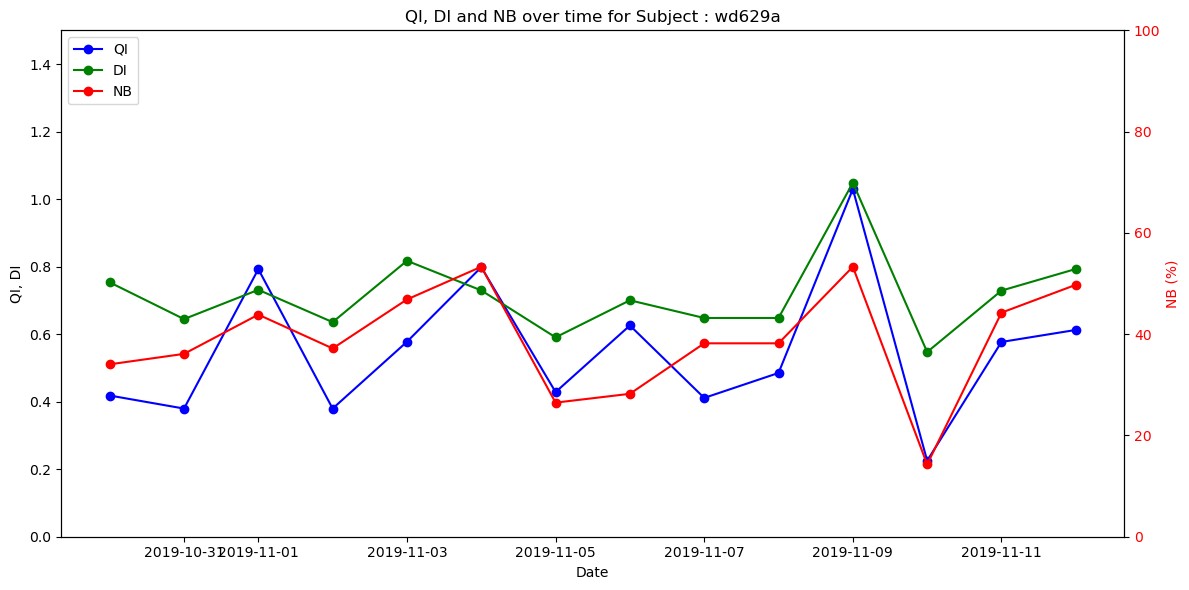

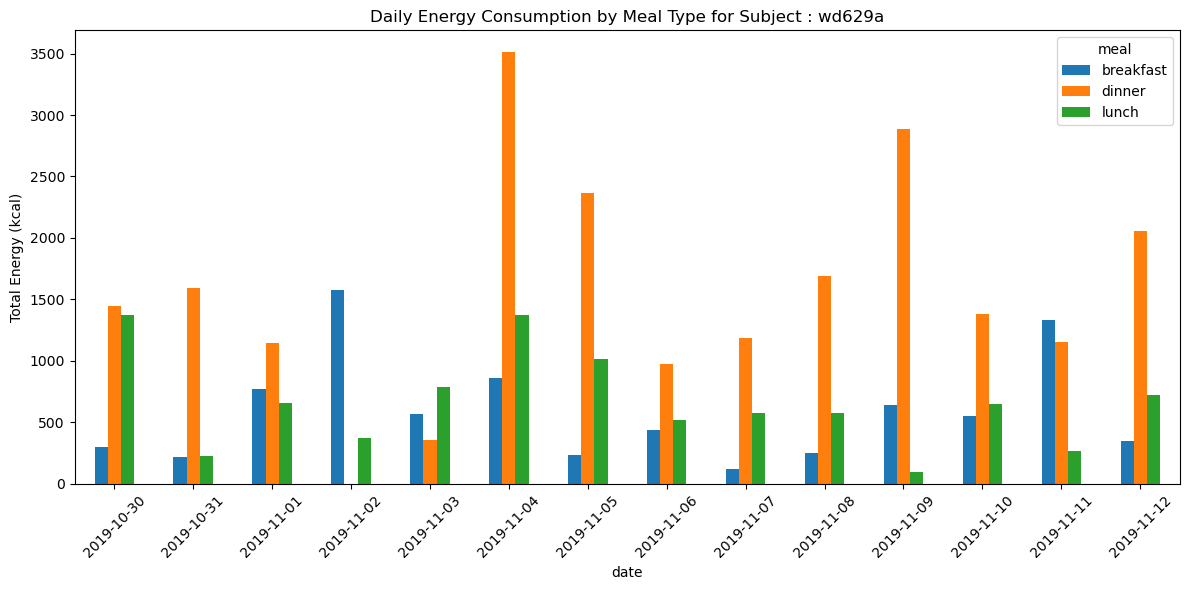

      subject_key        date        QI        DI         NB
13009      wd629a  2019-10-30  0.418242  0.753492  34.046820
13010      wd629a  2019-10-31  0.379604  0.644638  36.107274
13011      wd629a  2019-11-01  0.792564  0.731399  43.856111
13012      wd629a  2019-11-02  0.379604  0.635658  37.181275
13013      wd629a  2019-11-03  0.577516  0.817382  46.855053
13014      wd629a  2019-11-04  0.798477  0.729625  53.310040
13015      wd629a  2019-11-05  0.428476  0.590598  26.479450
13016      wd629a  2019-11-06  0.625771  0.700348  28.223079
13017      wd629a  2019-11-07  0.411153  0.647932  38.192191
13018      wd629a  2019-11-08  0.485072  0.647932  38.192191
13019      wd629a  2019-11-09  1.029670  1.048573  53.310040
13020      wd629a  2019-11-10  0.225155  0.547101  14.285714
13021      wd629a  2019-11-11  0.576907  0.729037  44.249182
13022      wd629a  2019-11-12  0.612510  0.793086  49.742675


In [82]:
subject_id = 'wd629a'
subject_daily, subject_meals, pivot_energy = plot_subject_daywise(subject_id, df_food_scaled)

C:\Users\Sophie\AppData\Local\Temp\ipykernel_8936\1070765091.py:7: DeprecationWarning: DataFrameGroupBy.apply operated on the grouping columns. This behavior is deprecated, and in a future version of pandas the grouping columns will be excluded from the operation. Either pass `include_groups=False` to exclude the groupings or explicitly select the grouping columns after groupby to silence this warning.
  meal_summary_weighted = (df_food_scaled.groupby(['subject_key', 'date', 'meal']).apply(aggregate_meal).reset_index())


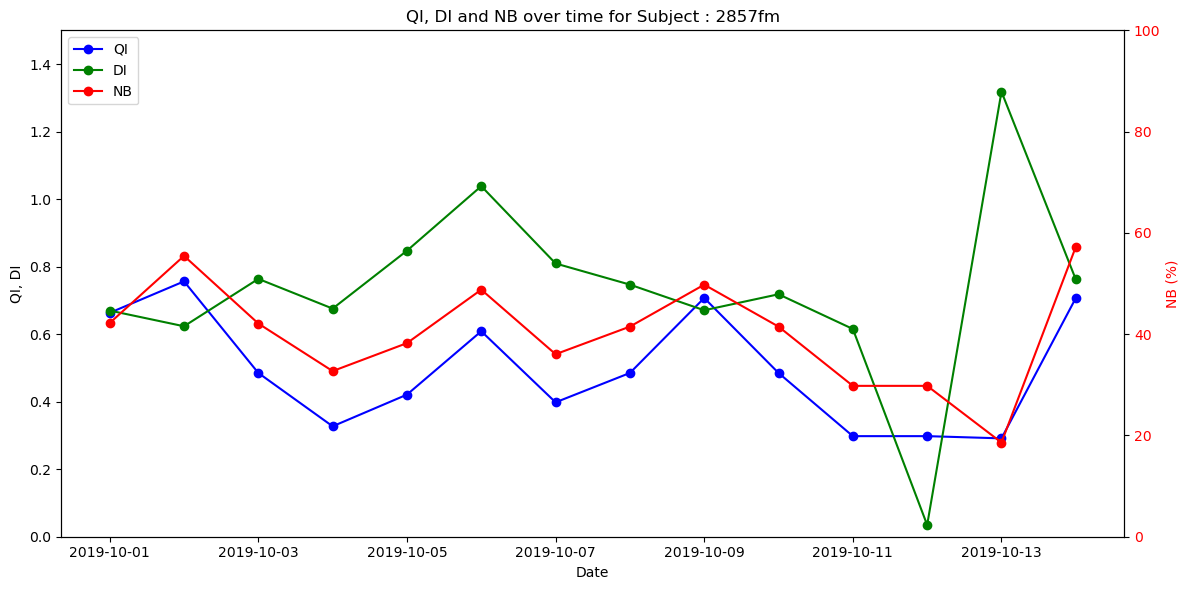

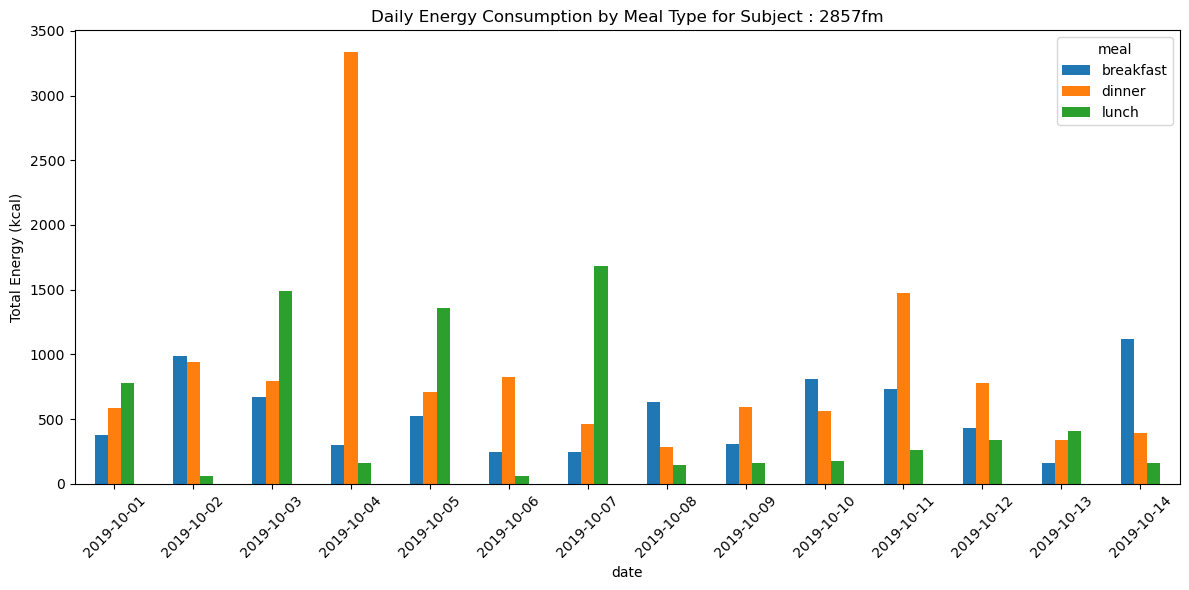

   subject_key        date        QI        DI         NB
56      2857fm  2019-10-01  0.663228  0.669905  42.201823
57      2857fm  2019-10-02  0.756382  0.623383  55.455843
58      2857fm  2019-10-03  0.485072  0.763788  42.103411
59      2857fm  2019-10-04  0.327075  0.675757  32.707453
60      2857fm  2019-10-05  0.420933  0.847247  38.232137
61      2857fm  2019-10-06  0.608654  1.038429  48.788888
62      2857fm  2019-10-07  0.398094  0.809386  36.044188
63      2857fm  2019-10-08  0.485072  0.746755  41.492872
64      2857fm  2019-10-09  0.707159  0.670787  49.775255
65      2857fm  2019-10-10  0.485072  0.718191  41.492872
66      2857fm  2019-10-11  0.297933  0.615385  29.793259
67      2857fm  2019-10-12  0.297933  0.034843  29.793259
68      2857fm  2019-10-13  0.291345  1.318266  18.602888
69      2857fm  2019-10-14  0.706880  0.762185  57.229446


In [83]:
subject_id = '2857fm'
subject_daily, subject_meals, pivot_energy = plot_subject_daywise(subject_id, df_food_scaled)

In [84]:
qi_ratios[qi_ratios['food_group'] == 'vegetables'].describe().T

,count,mean,std,min,25%,50%,75%,max
folate_eaten_ratio,2859.0,4.003006,4.258404,0.00,1.380952,2.439024,5.438596,41.304348
all_trans_retinol_equivalents_activity_eaten_ratio,2859.0,0.013313,0.134584,0.00,0.000000,0.000000,0.000000,1.696429
beta_carotene_eaten_ratio,2859.0,90.459651,175.522819,0.00,0.000000,4.285714,55.343915,597.515528
vitamin_c_eaten_ratio,2859.0,12.579208,25.681273,0.00,0.266667,2.962963,9.803922,145.641026
vitamin_d_eaten_ratio,2859.0,0.198328,2.067675,0.00,0.000000,0.000000,0.000000,23.703704
vitamin_e_activity_eaten_ratio,2859.0,1.858493,3.529405,0.00,0.139683,0.444444,1.777778,34.782609
calcium_eaten_ratio,2859.0,1.136838,1.380861,0.00,0.045714,0.701754,1.609756,8.695652
iron_eaten_ratio,2859.0,1.505054,1.585338,0.00,0.423280,1.322751,2.116402,13.777778
magnesium_eaten_ratio,2859.0,2.105659,2.134541,0.00,1.204268,1.785714,2.516234,19.354839
phosphorus_eaten_ratio,2859.0,2.574371,1.883587,0.00,1.785714,2.448980,3.809524,11.059908


In [85]:
di_ratios[di_ratios['food_group'] == 'vegetables'].describe().T

,count,mean,std,min,25%,50%,75%,max
fat_eaten_ratio,2859.0,0.344260,0.409149,0.000000,0.189934,0.233100,0.366300,2.727769
fatty_acids_saturated_eaten_ratio,2859.0,0.161120,0.439404,0.000000,0.000000,0.000000,0.173160,4.403409
cholesterol_eaten_ratio,2859.0,0.069922,0.812490,0.000000,0.000000,0.000000,0.000000,12.083333
sugar_eaten_ratio,2859.0,1.436634,1.032198,0.000000,0.594286,1.173333,2.552381,3.789474
sodium_eaten_ratio,2859.0,0.842665,2.354263,0.000000,0.006169,0.113095,0.614035,22.847222
salt_eaten_ratio,2859.0,0.776710,2.036569,0.000000,0.000000,0.000000,0.877193,24.561404
DI,2859.0,0.605219,0.707980,0.035613,0.283605,0.444587,0.684283,6.802561


Questions :

- Should I look at the ratio of each nutrient for a specific meal for an individual? Or should I look at for a whole day (because if we are looking at the impact of the vegetable specifically, breakfast isn't the meal where everyone eat vegetable)? 
- I don't think I have understood what I should do and what should I look at more into the different nutrient informations in the food_group vegetable. Because When I look at in general, the highest qi ratios in vegetables are the beta_caroten_ratio and the vitamin_c_ratio (which is )

## Daywise Nutrient Quality Assessment 

In [86]:
df_food_scaled_copy = df_food_scaled.copy()

ratio_cols_qi = [col for col in qi_ratios.columns if col.endswith('_ratio')]
ratio_cols_di = [col for col in di_ratios.columns if col.endswith('_ratio')]

df_food_scaled_copy = df_food_scaled_copy.join(qi_ratios[ratio_cols_qi])
df_food_scaled_copy = df_food_scaled_copy.join(di_ratios[ratio_cols_di])


In [87]:
subject_id = '02ae3856ca04'
target_date = pd.to_datetime('2018-11-26').date() 

df_day = df_food_scaled_copy[(df_food_scaled_copy['subject_key'] == subject_id) & (df_food_scaled['date'] == target_date)]
nutrient_ratio_cols = [col for col in df_day.columns if col.endswith('_ratio')]



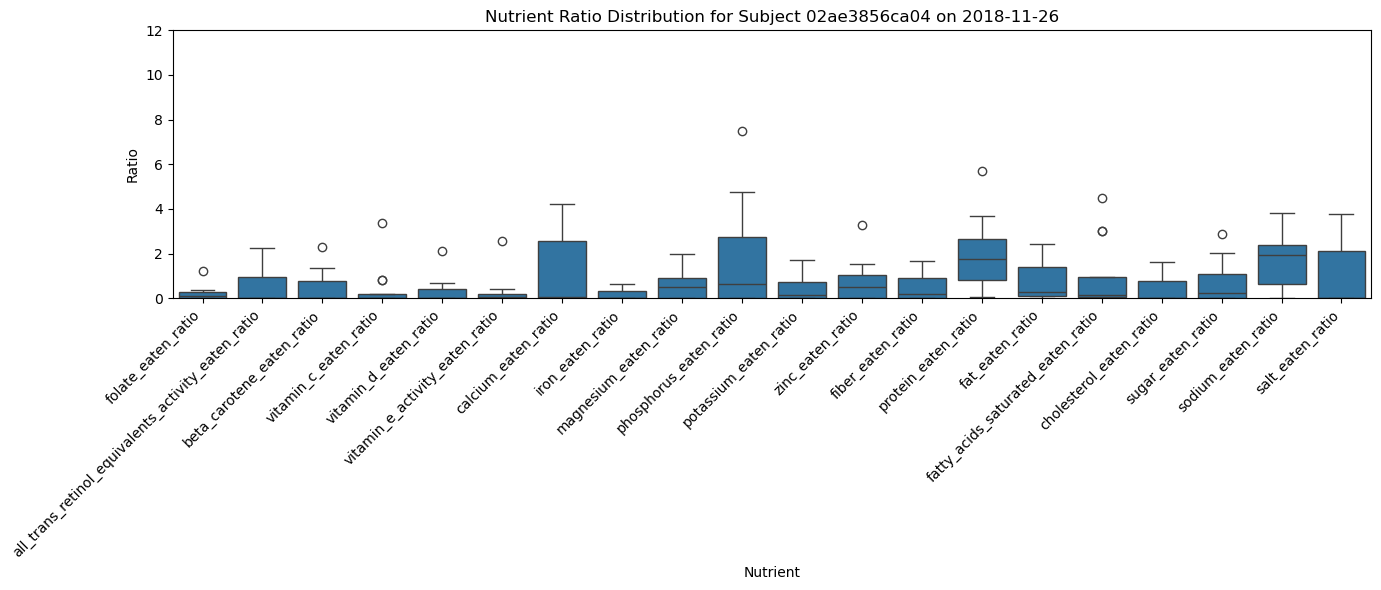

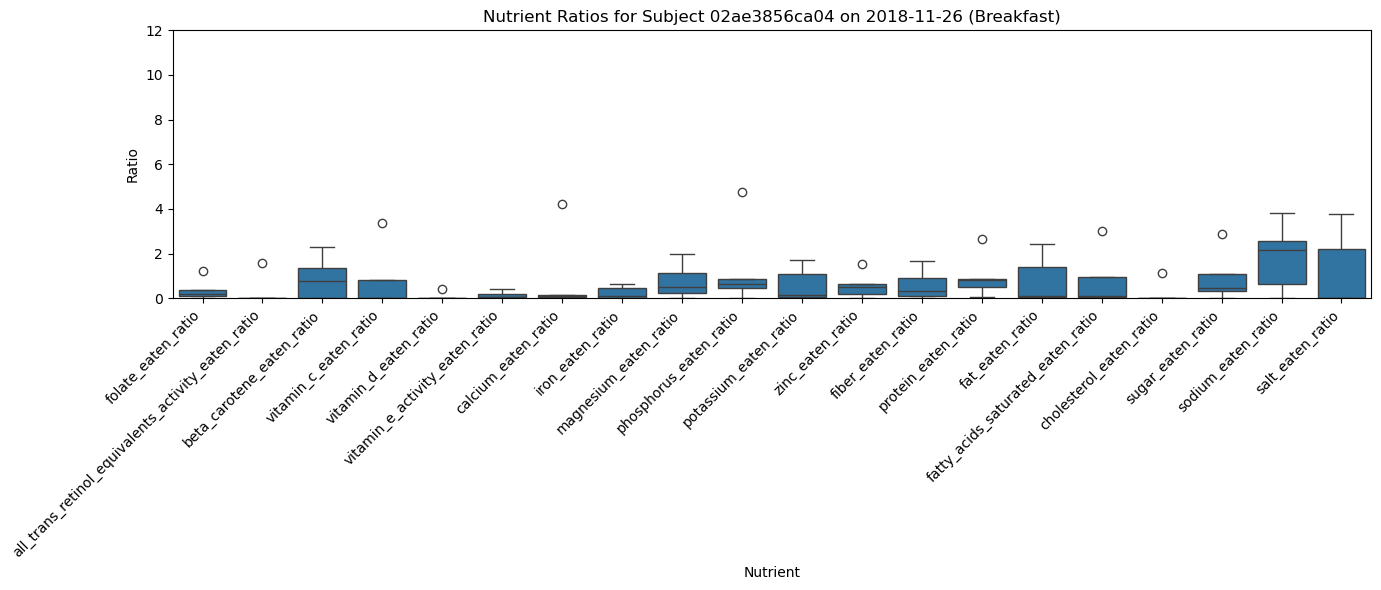

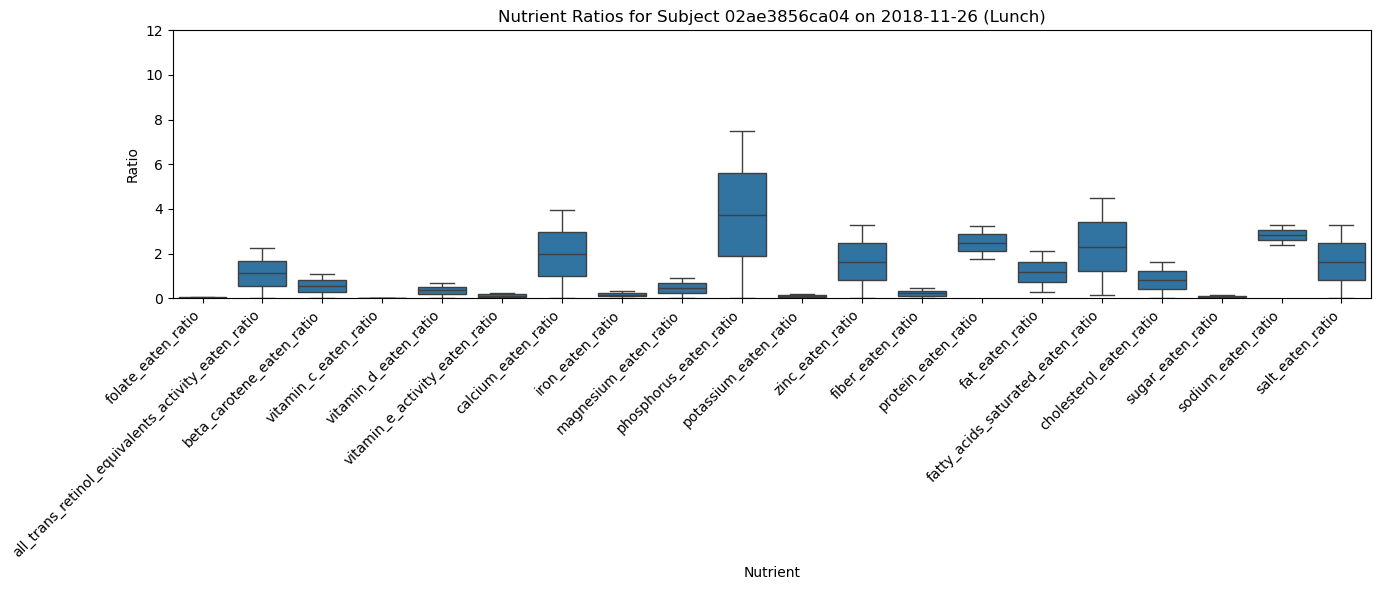

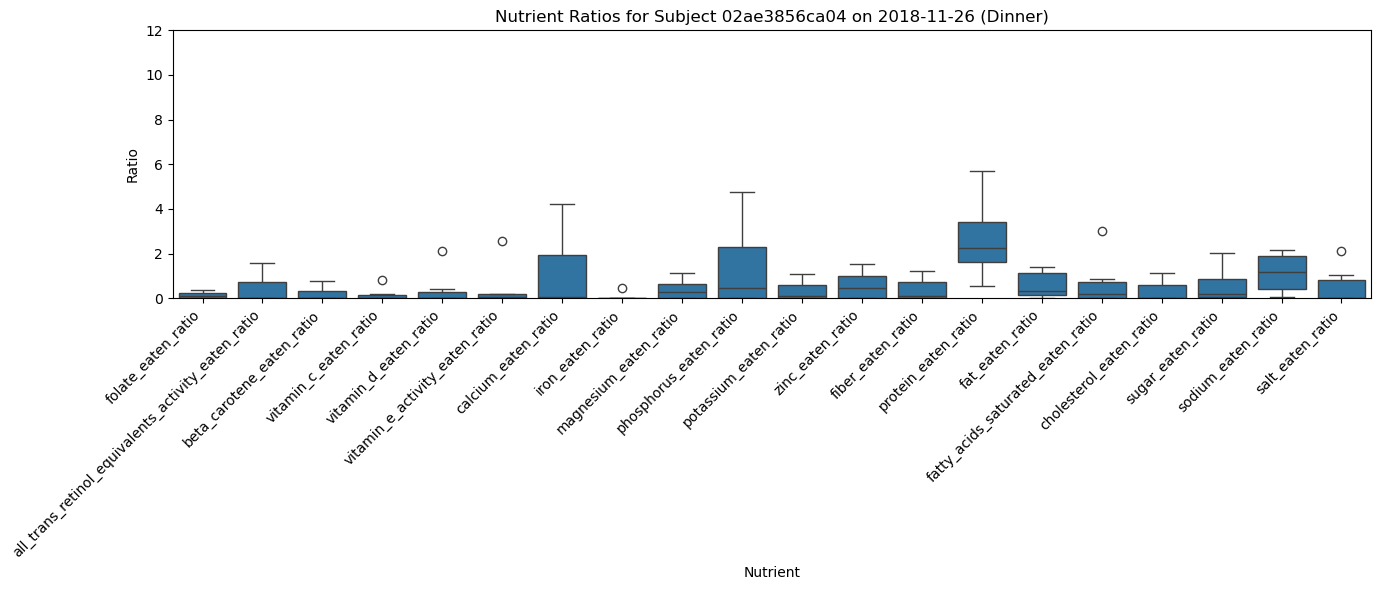

In [88]:
df_melted = pd.melt(df_day, id_vars=['combined_name'], value_vars=nutrient_ratio_cols, var_name='nutrient', value_name='ratio')

plt.figure(figsize=(14,6))
sns.boxplot(x='nutrient', y='ratio', data=df_melted)
plt.title(f'Nutrient Ratio Distribution for Subject {subject_id} on {target_date}')
plt.xlabel('Nutrient')
plt.ylabel('Ratio')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 12)
plt.tight_layout()
plt.show()

meal_types = ['breakfast', 'lunch', 'dinner']

for meal in meal_types:
    df_meal = df_day[df_day['meal'] == meal]
    if df_meal.empty:
        print(f"No data for {meal} on {target_date} for subject {subject_id}.")
        continue
    
    # Melt the DataFrame to long format for boxplotting
    df_melted = pd.melt(df_meal, id_vars=['combined_name'], value_vars=nutrient_ratio_cols, var_name='nutrient',value_name='ratio')
    
    plt.figure(figsize=(14, 6))
    sns.boxplot(x='nutrient', y='ratio', data=df_melted)
    plt.title(f'Nutrient Ratios for Subject {subject_id} on {target_date} ({meal.capitalize()})')
    plt.xlabel('Nutrient')
    plt.ylabel('Ratio')
    plt.xticks(rotation=45, ha='right')
    plt.ylim(0, 12)
    plt.tight_layout()
    plt.show()


## Distribution Plot for QI, DI and NB by food group

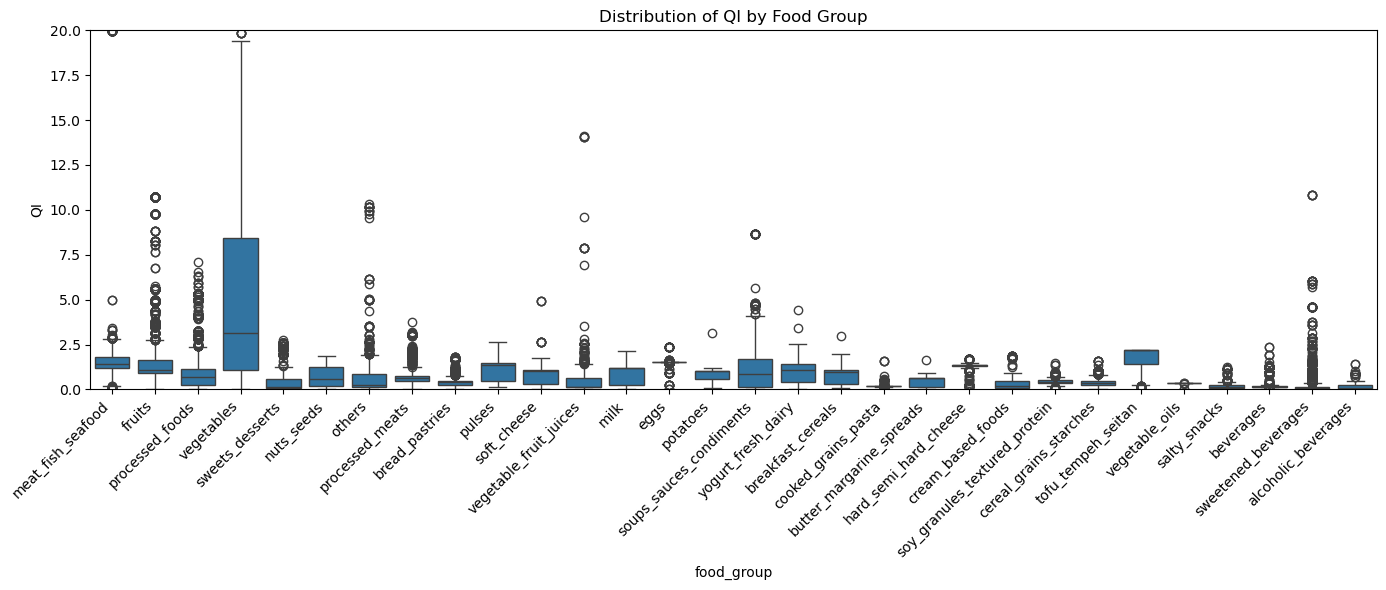

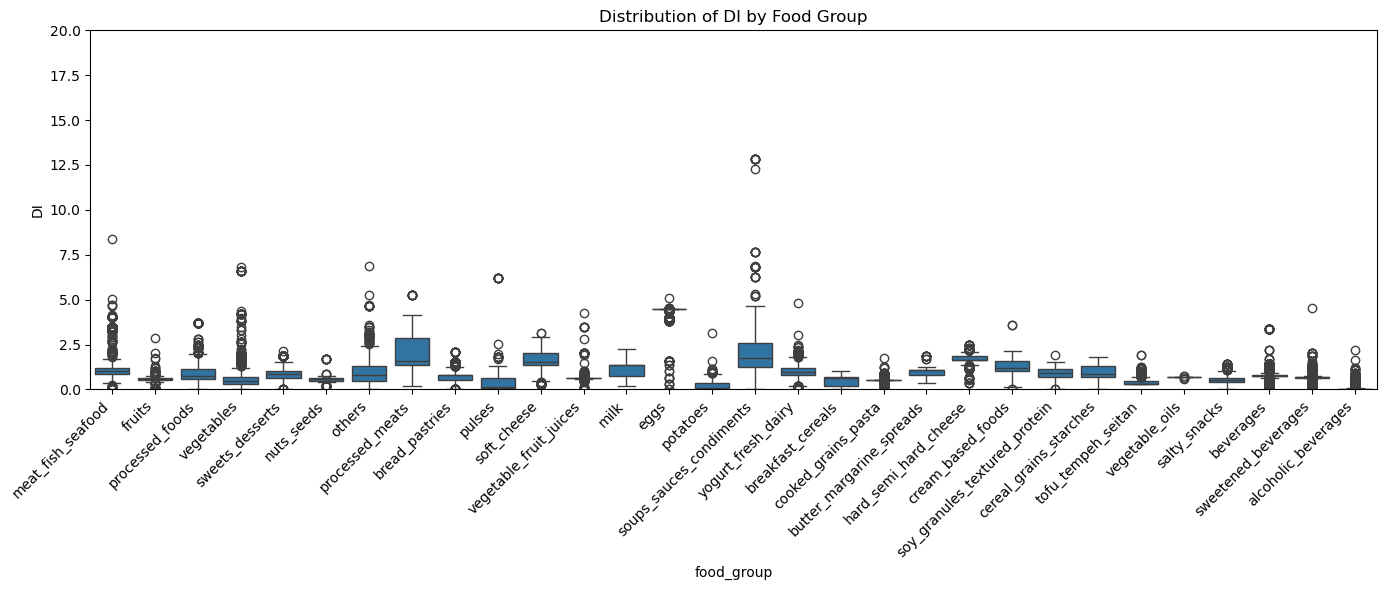

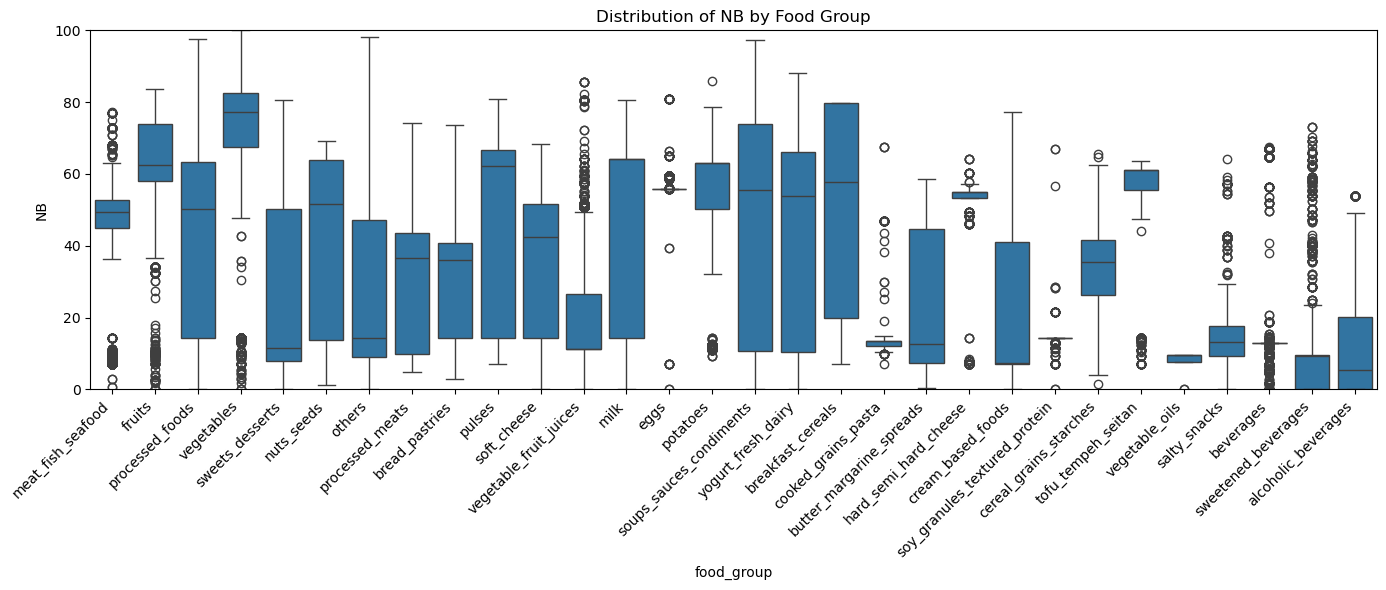

In [89]:
plt.figure(figsize=(14, 6))
sns.boxplot(x='food_group', y='QI', data=df_food_scaled_copy)
plt.title('Distribution of QI by Food Group')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='food_group', y='DI', data=df_food_scaled_copy)
plt.title('Distribution of DI by Food Group')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 20)
plt.tight_layout()
plt.show()

plt.figure(figsize=(14, 6))
sns.boxplot(x='food_group', y='NB', data=df_food_scaled_copy)
plt.title('Distribution of NB by Food Group')
plt.xticks(rotation=45, ha='right')
plt.ylim(0, 100)
plt.tight_layout()
plt.show()

## Heatmap of Nutrient ratio

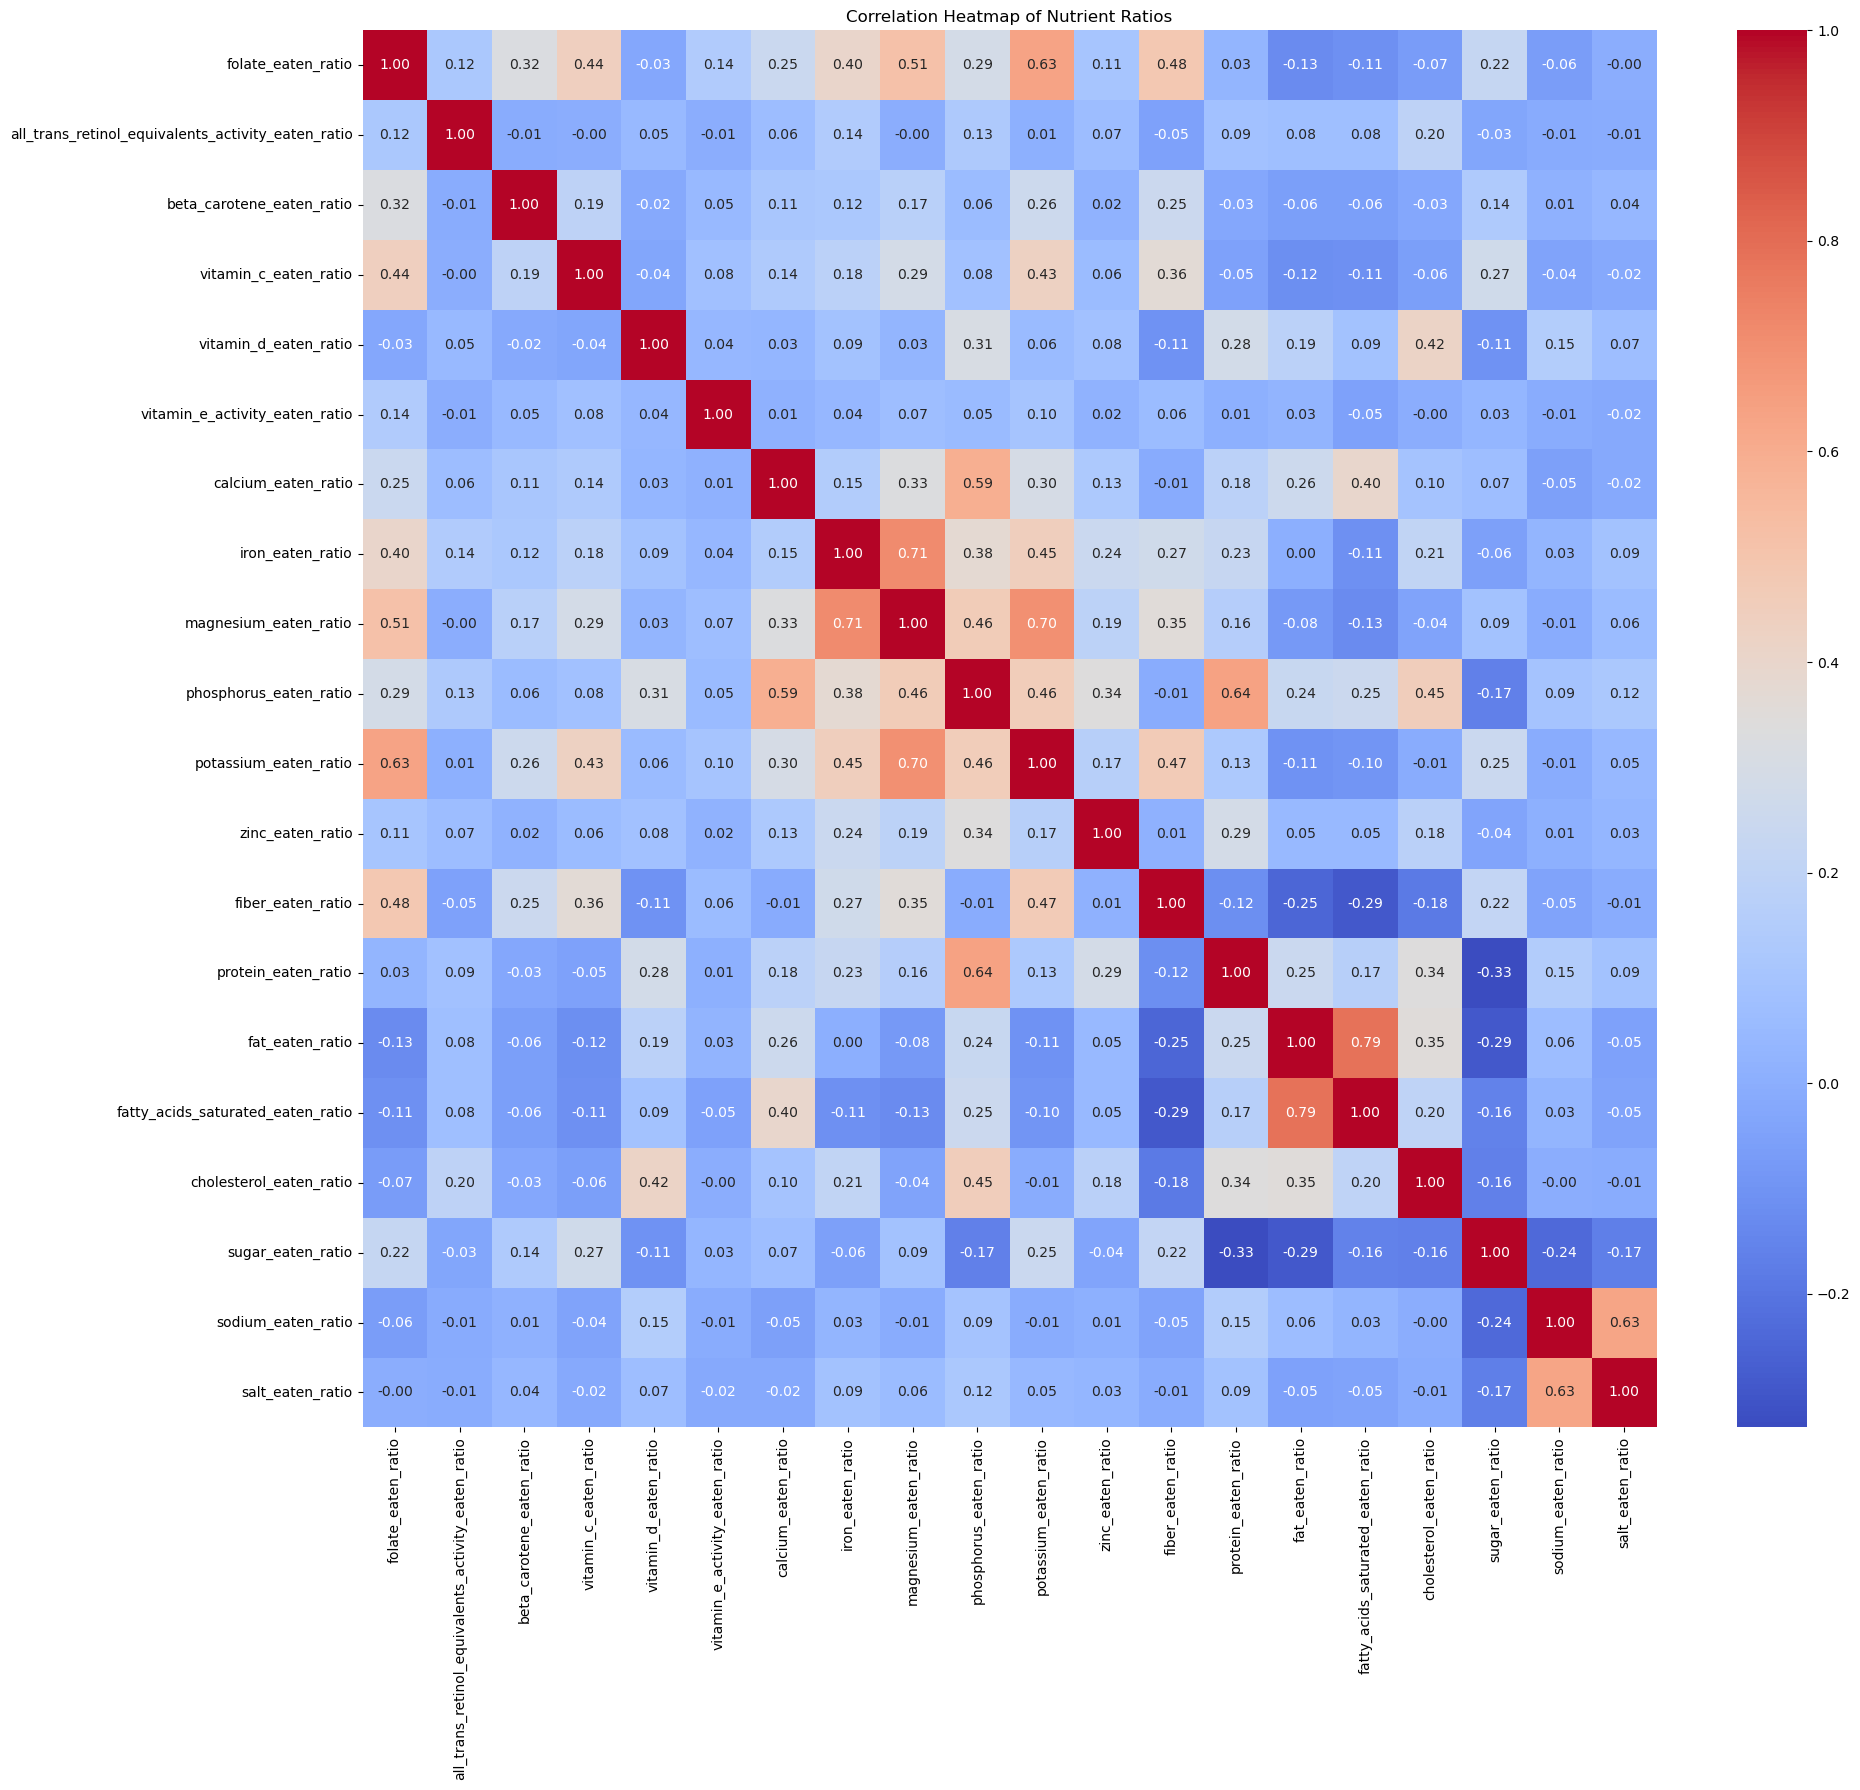

In [90]:
ratio_cols = [col for col in df_food_scaled_copy.columns if col.endswith('_ratio')]

corr_matrix = df_food_scaled_copy[ratio_cols].corr()

plt.figure(figsize=(20,18))
sns.heatmap(corr_matrix, annot=True, cmap='coolwarm', fmt=".2f")
plt.title('Correlation Heatmap of Nutrient Ratios')
plt.tight_layout()
plt.show()

## Relationship of Nutrient Balance to Qualifying Index (QI)

In [91]:
def plot_qi_nb_scatter(subject_id, df_food_scaled, start_date=None, end_date=None):
    

    subject_df = df_food_scaled[df_food_scaled['subject_key'] == subject_id].copy()
    
    # Look at specific time frame
    if start_date is not None:
        subject_df = subject_df[subject_df['date'] >= start_date]
    if end_date is not None:
        subject_df = subject_df[subject_df['date'] <= end_date]

  
    daily_agg = (subject_df.groupby('date')[['QI', 'NB']].median().reset_index())
    

    plt.figure(figsize=(10, 8))
    
    # Individual meal components
    plt.scatter(subject_df['QI'], subject_df['NB'], color='black', alpha=0.7, label='Individual Meal Components')
    
    # Daily aggregated values 
    plt.scatter(daily_agg['QI'], daily_agg['NB'], color='red', s=80, label='Daily Combined Meals')
    
    
    plt.axvline(x=1, color='black', linestyle='--', alpha=1)
   
    plt.xlabel('Qualifying Index (QI)')
    plt.ylabel('% Nutrient Balance (NB)')
    plt.xlim(0, 14)
    plt.title(f'QI vs NB for Subject : {subject_id}')
    plt.legend()
    plt.grid(True, alpha=0.3)
    plt.tight_layout()
    plt.show()

    print(daily_agg)


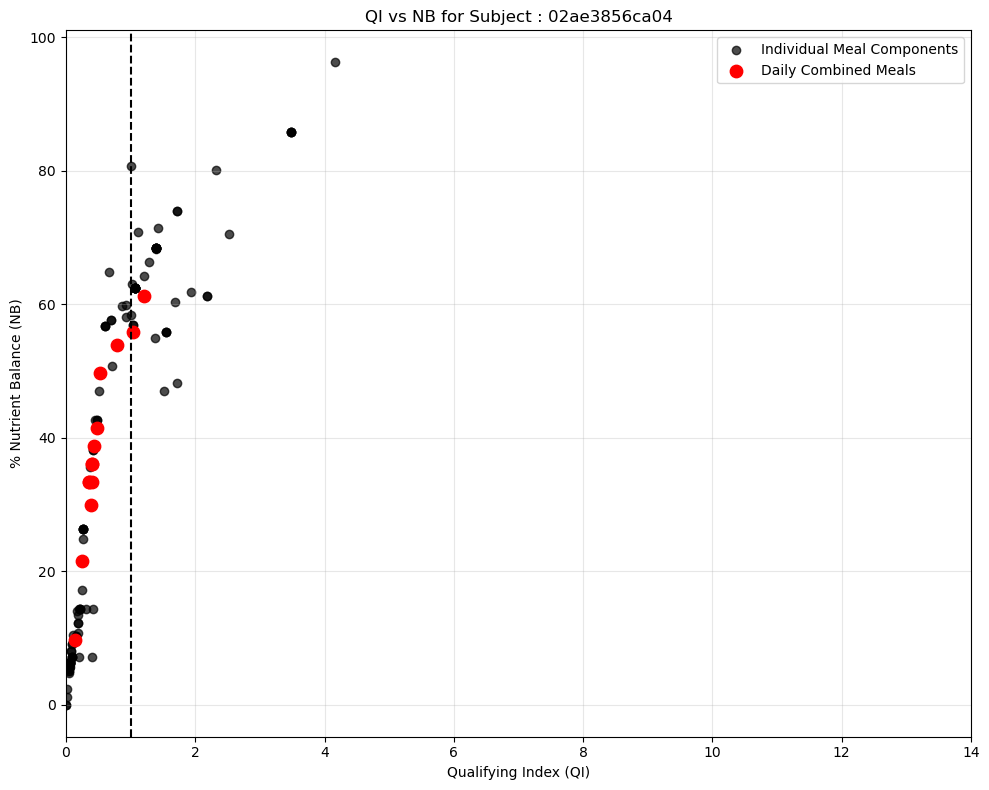

          date        QI         NB
0   2018-11-26  0.408630  33.354575
1   2018-11-27  0.398094  36.044188
2   2018-11-28  0.485072  41.492872
3   2018-11-29  0.398094  36.044188
4   2018-11-30  0.441583  38.768530
5   2018-12-01  1.042181  55.882138
6   2018-12-02  0.788587  53.825697
7   2018-12-03  0.395433  29.849223
8   2018-12-04  1.207900  61.234318
9   2018-12-05  0.358758  33.354575
10  2018-12-06  0.358758  33.354575
11  2018-12-07  0.532278  49.670662
12  2018-12-08  0.137936   9.715461
13  2018-12-09  0.246642  21.593523


In [92]:
subject_id = '02ae3856ca04'
start_date = pd.to_datetime('2018-11-26').date()
end_date = pd.to_datetime('2018-12-09').date()

plot_qi_nb_scatter(subject_id, df_food_scaled_copy, start_date, end_date)


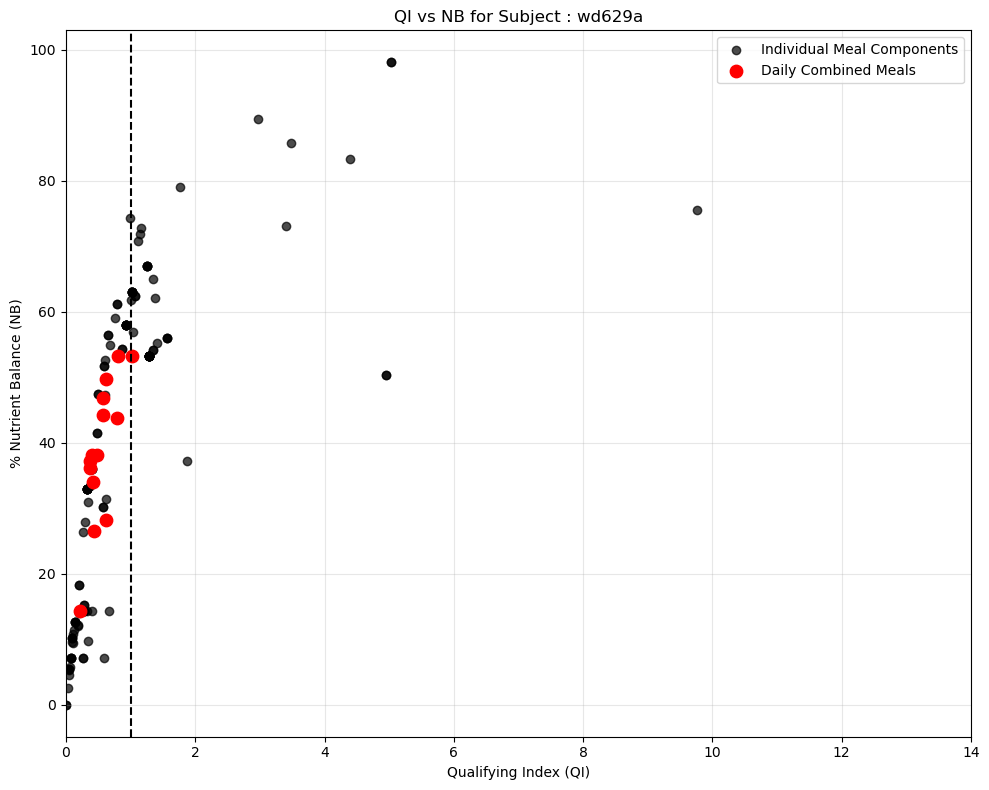

          date        QI         NB
0   2019-10-30  0.418242  34.046820
1   2019-10-31  0.379604  36.107274
2   2019-11-01  0.792564  43.856111
3   2019-11-02  0.379604  37.181275
4   2019-11-03  0.577516  46.855053
5   2019-11-04  0.798477  53.310040
6   2019-11-05  0.428476  26.479450
7   2019-11-06  0.625771  28.223079
8   2019-11-07  0.411153  38.192191
9   2019-11-08  0.485072  38.192191
10  2019-11-09  1.029670  53.310040
11  2019-11-10  0.225155  14.285714
12  2019-11-11  0.576907  44.249182
13  2019-11-12  0.612510  49.742675


In [93]:
subject_id = 'wd629a'
start_date = pd.to_datetime('2019-10-30').date()
end_date = pd.to_datetime('2019-11-12').date()

plot_qi_nb_scatter(subject_id, df_food_scaled_copy, start_date, end_date)

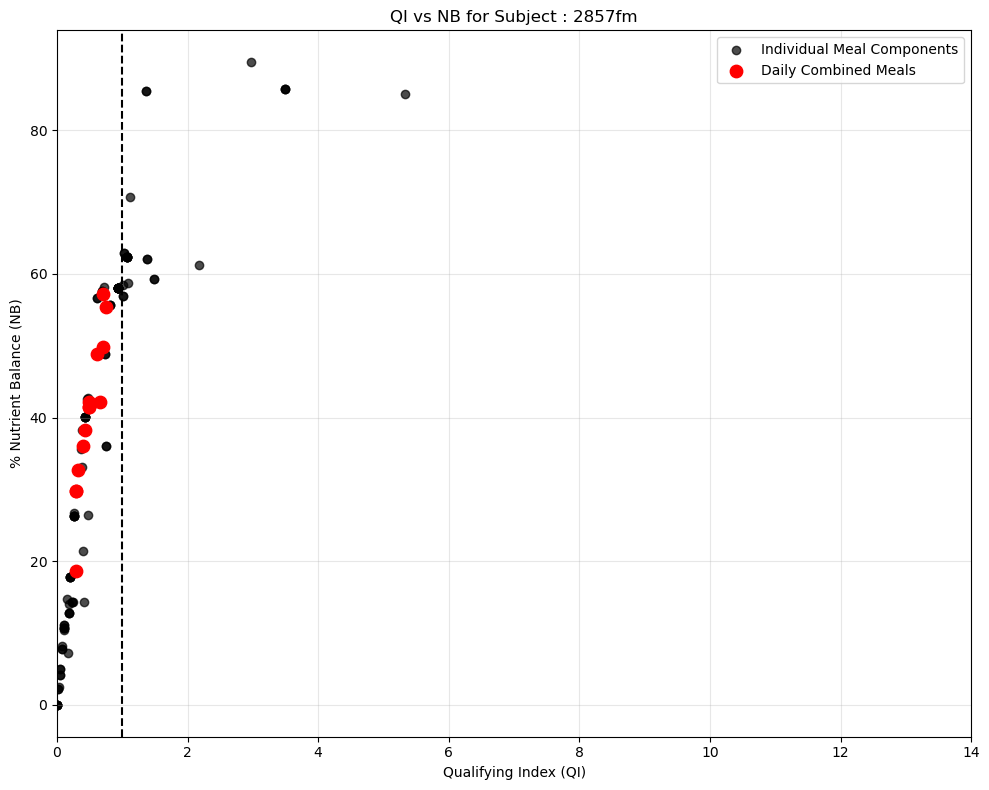

          date        QI         NB
0   2019-10-01  0.663228  42.201823
1   2019-10-02  0.756382  55.455843
2   2019-10-03  0.485072  42.103411
3   2019-10-04  0.327075  32.707453
4   2019-10-05  0.420933  38.232137
5   2019-10-06  0.608654  48.788888
6   2019-10-07  0.398094  36.044188
7   2019-10-08  0.485072  41.492872
8   2019-10-09  0.707159  49.775255
9   2019-10-10  0.485072  41.492872
10  2019-10-11  0.297933  29.793259
11  2019-10-12  0.297933  29.793259
12  2019-10-13  0.291345  18.602888
13  2019-10-14  0.706880  57.229446


In [94]:
subject_id = '2857fm'
start_date = pd.to_datetime('2019-10-01').date()
end_date = pd.to_datetime('2019-10-14').date()

plot_qi_nb_scatter(subject_id, df_food_scaled_copy, start_date, end_date)

## Descriptive statistics by nutrient (comparing food group)

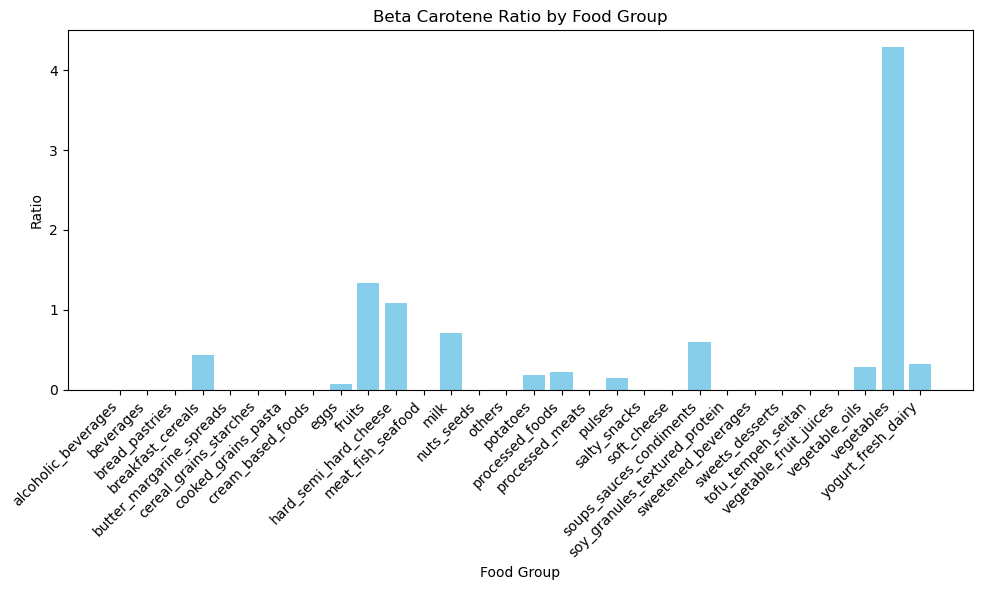

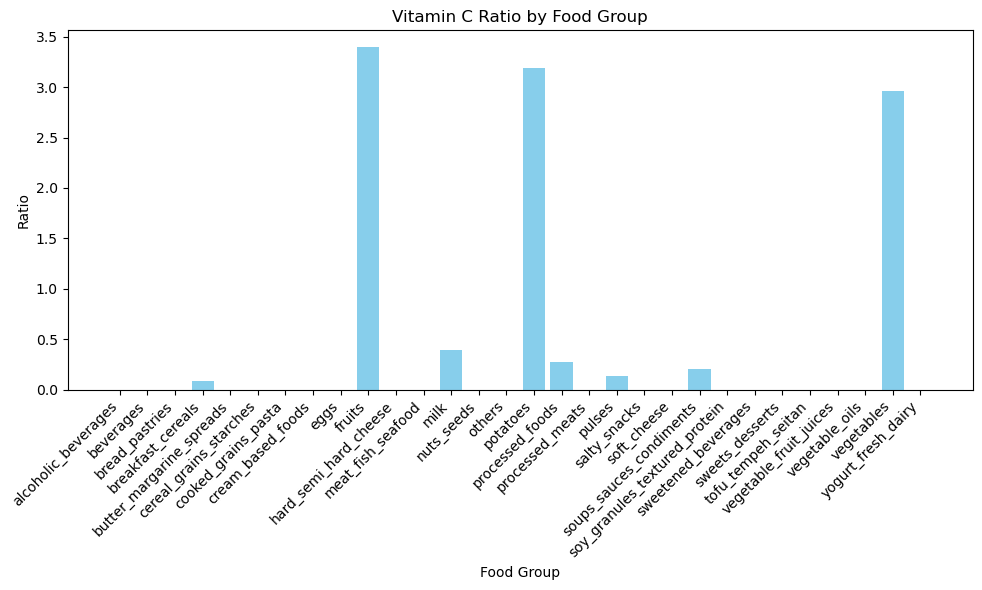

In [95]:
# Compute median beta_carotene_eaten_ratio for each food group
beta_caroten = df_food_scaled_copy.groupby('food_group')['beta_carotene_eaten_ratio'].median().reset_index()
vitamin_c = df_food_scaled_copy.groupby('food_group')['vitamin_c_eaten_ratio'].median().reset_index()

plt.figure(figsize=(10,6))
plt.bar(beta_caroten['food_group'], beta_caroten['beta_carotene_eaten_ratio'], color='skyblue')
plt.xlabel('Food Group')
plt.ylabel('Ratio')
plt.title('Beta Carotene Ratio by Food Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()

plt.figure(figsize=(10,6))
plt.bar(vitamin_c['food_group'], vitamin_c['vitamin_c_eaten_ratio'], color='skyblue')
plt.xlabel('Food Group')
plt.ylabel('Ratio')
plt.title('Vitamin C Ratio by Food Group')
plt.xticks(rotation=45, ha='right')
plt.tight_layout()
plt.show()


In [96]:
qi_ratios[qi_ratios['food_group'] == 'vegetables'].describe().T

,count,mean,std,min,25%,50%,75%,max
folate_eaten_ratio,2859.0,4.003006,4.258404,0.00,1.380952,2.439024,5.438596,41.304348
all_trans_retinol_equivalents_activity_eaten_ratio,2859.0,0.013313,0.134584,0.00,0.000000,0.000000,0.000000,1.696429
beta_carotene_eaten_ratio,2859.0,90.459651,175.522819,0.00,0.000000,4.285714,55.343915,597.515528
vitamin_c_eaten_ratio,2859.0,12.579208,25.681273,0.00,0.266667,2.962963,9.803922,145.641026
vitamin_d_eaten_ratio,2859.0,0.198328,2.067675,0.00,0.000000,0.000000,0.000000,23.703704
vitamin_e_activity_eaten_ratio,2859.0,1.858493,3.529405,0.00,0.139683,0.444444,1.777778,34.782609
calcium_eaten_ratio,2859.0,1.136838,1.380861,0.00,0.045714,0.701754,1.609756,8.695652
iron_eaten_ratio,2859.0,1.505054,1.585338,0.00,0.423280,1.322751,2.116402,13.777778
magnesium_eaten_ratio,2859.0,2.105659,2.134541,0.00,1.204268,1.785714,2.516234,19.354839
phosphorus_eaten_ratio,2859.0,2.574371,1.883587,0.00,1.785714,2.448980,3.809524,11.059908
